In [1]:
#this is to auto-reload modules (like utils.py)
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
from IPython.display import clear_output

import os
import sys
import time
import gc
import json
import glob
import ast

import shutil
import joblib
import itertools

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)


#needed to import utils.py
sys.path.append('../') 

import utils
import utils_exec_models
import utils_exec_models_new

import numpy as np
import pandas as pd
# config to not reduce column width
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)


import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm, ListedColormap

import seaborn as sns
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except:
    plt.style.use('seaborn-whitegrid')

    
import plotly as ply
import plotly.express as px

from itertools import permutations, combinations

from tabulate import tabulate

import pickle
from joblib import dump, load


import sklearn
from sklearn.model_selection import StratifiedKFold, ParameterGrid
from sklearn.model_selection import GridSearchCV, cross_validate, train_test_split
from sklearn.pipeline import Pipeline

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import ComplementNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier, AdaBoostClassifier


# from xgboost import XGBClassifier
# from catboost import CatBoostClassifier


import imblearn.under_sampling as resus
import imblearn.ensemble as resemb
import imblearn.combine as reshyb
from imblearn.over_sampling  import SMOTE


import shap
shap.initjs()

import interpret

from collections import Counter


# import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)
# warnings.filterwarnings('always')

# Surpress warnings:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn




SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

%matplotlib inline  



### Get Training, Validation, Balanced sets 

##### NOTE: the "training_sets" contains the sets of training and validation to help the models execution, with the following information:
 - `Dataset Info `  ["Training", "Training Balanced"]
 - `Features Info`  ["All Features", "Feature Selection"]
 - `"X" to train`   
 - `"y" to train` 
 - `"X" to validation`


In [2]:
# get train and tezt sets INCLUDING the Diagnosis_Delay feature
X_train, y_train, X_valid, y_valid = utils.get_train_and_validation_data(
    scaled=True,
    use_diagnosis_delay=True
)

X_all = pd.concat([X_train, X_valid])
y_all = np.concatenate((y_train, y_valid))

# X_all['Survival_Group'] = y_all


display(X_all)

Sex_Male  Site_Onset  Diagnosis_Delay  Age_at_Onset  Riluzole  FVC_at_Diagnosis  BMI_at_Diagnosis  Q1_Speech_slope_at_Diagnosis  Q2_Salivation_slope_at_Diagnosis  Q3_Swallowing_slope_at_Diagnosis  Q4_Handwriting_slope_at_Diagnosis  Q5_Cutting_slope_at_Diagnosis  Q6_Dressing_and_Hygiene_slope_at_Diagnosis  Q7_Turning_in_Bed_slope_at_Diagnosis  Q8_Walking_slope_at_Diagnosis  Q9_Climbing_Stairs_slope_at_Diagnosis  Q10_Respiratory_slope_at_Diagnosis  Qty_Regions_Involved_at_Diagnosis  Region_Involved_Bulbar_at_Diagnosis  Region_Involved_Upper_Limb_at_Diagnosis  Region_Involved_Lower_Limb_at_Diagnosis  Region_Involved_Respiratory_at_Diagnosis  Patient_with_Gastrostomy_at_Diagnosis
0         1.0         1.0              0.0          0.50       0.0               1.0              0.67                           0.0                               0.0                               0.0                                0.0                            0.0                                         0.0                                   0.0                            0.0                                    0.0                                 0.0                               0.67                                  1.0                                      1.0                                      1.0                                       0.0                                    0.0
1         1.0         1.0              0.5          0.75       0.0               0.0              0.67                           0.0                               0.0                               0.0                                0.0                            0.5                                         0.5                                   0.0                            0.0                                    0.5                                 0.0                               0.67                                  1.0                                      1.0                                      1.0                                       0.0                                    0.0
2         1.0         1.0              0.0          0.25       0.0               1.0              0.33                           0.5                               0.0                               0.0                                0.5                            0.5                                         0.5                                   0.0                            0.0                                    0.5                                 0.0                               0.67                                  1.0                                      1.0                                      1.0                                       0.0                                    0.0
3         0.0         0.0              0.5          0.50       0.0               1.0              1.00                           0.5                               0.5                               0.5                                0.0                            0.0                                         0.5                                   0.5                            0.5                                    0.5                                 0.5                               0.67                                  1.0                                      0.0                                      1.0                                       1.0                                    0.0
4         1.0         0.0              1.0          0.75       0.0               0.0              1.00                           0.0                               0.0                               0.0                                0.0                            0.0                                         0.0                                   0.0                            0.0                                    0.5                                 0.0                               1.00                                  1.0                             

In [88]:
# X_train, X_train_fs, y_train, \
# X_train_balanced, X_train_fs_balanced, y_train_balanced,\
# X_valid, X_valid_fs, y_valid, training_sets = utils.get_train_and_validation_data(
#     return_training_sets=True
# )


# X_all = pd.concat([X_train, X_valid])
# X_all_fs = pd.concat([X_train_fs, X_valid_fs])
# y_all = np.concatenate((y_train, y_valid))


# display(X_train)


---
# Create the best model selected between the bests

In [3]:
# BalancedBaggingClassifier + NN

estimator = MLPClassifier(activation='tanh',alpha=0.1,hidden_layer_sizes=30,learning_rate='adaptive',learning_rate_init=0.7,max_iter=2000,random_state=42)

params = {'n_estimators':101,'random_state':42,'replacement':True,'sampling_strategy':'auto','warm_start':False}

clf = resemb.BalancedBaggingClassifier(estimator=estimator, **params)

clf



BalancedBaggingClassifier(estimator=MLPClassifier(activation='tanh', alpha=0.1,
                                                  hidden_layer_sizes=30,
                                                  learning_rate='adaptive',
                                                  learning_rate_init=0.7,
                                                  max_iter=2000,
                                                  random_state=42),
                          n_estimators=101, random_state=42, replacement=True)

---
# Train the best model using the $Training$ set 

In [4]:
clf.fit(X=X_train, y=y_train)

BalancedBaggingClassifier(estimator=MLPClassifier(activation='tanh', alpha=0.1,
                                                  hidden_layer_sizes=30,
                                                  learning_rate='adaptive',
                                                  learning_rate_init=0.7,
                                                  max_iter=2000,
                                                  random_state=42),
                          n_estimators=101, random_state=42, replacement=True)

---
# Make predictions using the Validation set

In [5]:
y_pred = clf.predict(X=X_valid)
y_pred_proba = clf.predict_proba(X=X_valid)[:,1]

#get performance
bal_acc, sens, spec, auc, acc, prec, f1 = utils_exec_models_new.get_performances_from_predictions(
    y_validation=y_valid, 
    y_pred=y_pred,
    y_pred_proba=y_pred_proba,
)

performance = {
    'bacc': bal_acc,
    'sens': sens,
    'spec': spec,
    'auc': auc,
}

print(performance)



{'bacc': 0.88, 'sens': 0.96, 'spec': 0.8, 'auc': 0.93}


---
---
# Perform SHAP to analyze the feature importances

In [6]:
explainer = shap.KernelExplainer(clf.predict, X_valid, feature_names=X_valid.columns)
shap_values = explainer(X_valid)

file_explainer = 'saved_shap_explainer/SHAP_KernelExplainer_BalBag_NN.model'
with open(file_explainer, 'wb') as file:
    pickle.dump(explainer, file)


#save SHAP Values object
file_explainer_values = 'saved_shap_explainer/SHAP_KernelExplainer_values_BalBag_NN.model'
with open(file_explainer_values, 'wb') as file:
    pickle.dump(shap_values, file)


Using 394 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/394 [00:00<?, ?it/s]

In [105]:
#Get shap values
# explainer = shap.TreeExplainer(clf)
# shap_values = explainer.shap_values(X_valid)

# explainer = shap.TreeExplainer(model)
# shap_values = explainer.shap_values(X))

# explainer = shap.Explainer(clf.predict, X_all, feature_names=X_all.columns)
# shap_values = explainer(X_all)

Permutation explainer: 1968it [00:47, 32.71it/s]                                


In [107]:
# file_explainer = 'saved_shap_explainer/SHAP_Explainer_BalBag_DT.model'
# with open(file_explainer, 'wb') as file:
#     pickle.dump(explainer, file)

# # to_serialize = open(file, 'wb') 
# # pickle.dump(explainer, to_serialize)

# #save SHAP Values object
# file_explainer_values = 'saved_shap_explainer/SHAP_Explainer_values_BalBag_DT.model'
# with open(file_explainer_values, 'wb') as file:
#     pickle.dump(shap_values, file)

# to_serialize = open(file, 'wb') 
# pickle.dump(shap_values, to_serialize)


In [106]:
explainer.feature_names

Index(['Sex_Male', 'Site_Onset', 'Diagnosis_Delay', 'Age_at_Onset', 'Riluzole',
       'FVC_at_Diagnosis', 'BMI_at_Diagnosis', 'Q1_Speech_slope_at_Diagnosis',
       'Q2_Salivation_slope_at_Diagnosis', 'Q3_Swallowing_slope_at_Diagnosis',
       'Q4_Handwriting_slope_at_Diagnosis', 'Q5_Cutting_slope_at_Diagnosis',
       'Q6_Dressing_and_Hygiene_slope_at_Diagnosis',
       'Q7_Turning_in_Bed_slope_at_Diagnosis', 'Q8_Walking_slope_at_Diagnosis',
       'Q9_Climbing_Stairs_slope_at_Diagnosis',
       'Q10_Respiratory_slope_at_Diagnosis',
       'Qty_Regions_Involved_at_Diagnosis',
       'Region_Involved_Bulbar_at_Diagnosis',
       'Region_Involved_Upper_Limb_at_Diagnosis',
       'Region_Involved_Lower_Limb_at_Diagnosis',
       'Region_Involved_Respiratory_at_Diagnosis',
       'Patient_with_Gastrostomy_at_Diagnosis'],
      dtype='object')

-------------
Beeswarm plot
-------------


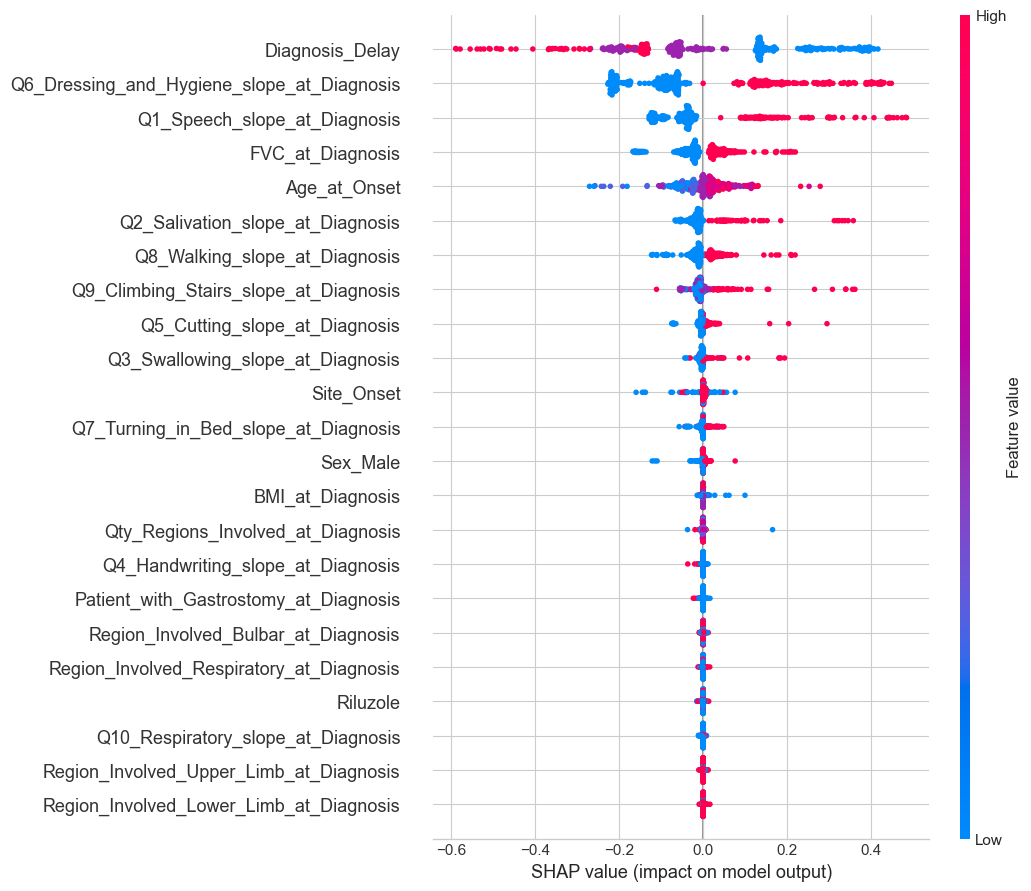

---------
Mean SHAP
---------


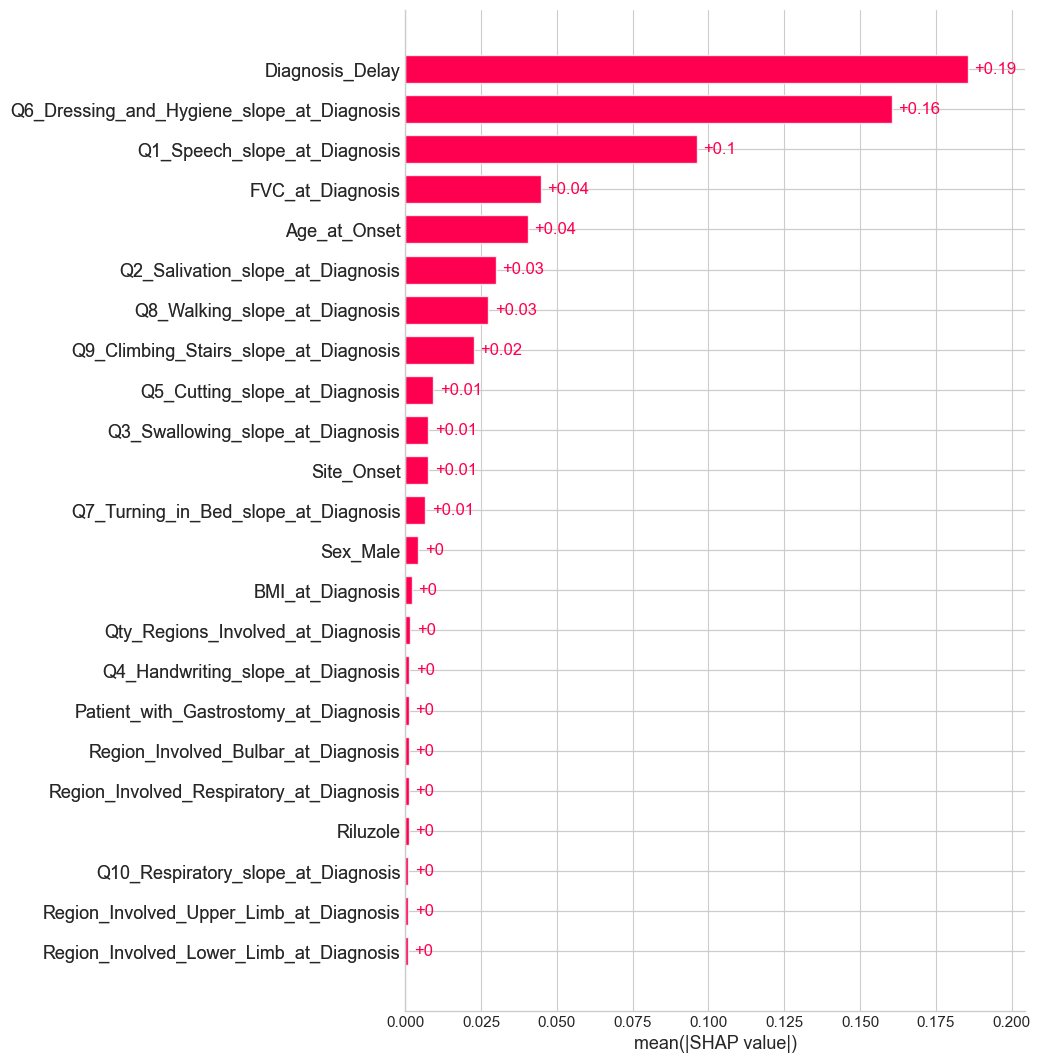

In [111]:
utils.print_string_with_separators('Beeswarm plot')
shap.plots.beeswarm(shap_values, max_display=25)

utils.print_string_with_separators('Mean SHAP')
shap.plots.bar(shap_values, max_display=25)


Sex   Site_Onset Diagnosis_Delay Age_at_Onset Riluzole FVC_at_Diagnosis BMI_at_Diagnosis Q1_Speech_slope_at_Diagnosis Q2_Salivation_slope_at_Diagnosis Q3_Swallowing_slope_at_Diagnosis Q4_Handwriting_slope_at_Diagnosis Q5_Cutting_slope_at_Diagnosis Q6_Dressing_and_Hygiene_slope_at_Diagnosis Q7_Turning_in_Bed_slope_at_Diagnosis Q8_Walking_slope_at_Diagnosis Q9_Climbing_Stairs_slope_at_Diagnosis Q10_Respiratory_slope_at_Diagnosis Qty_Regions_Involved_at_Diagnosis Region_Involved_Bulbar_at_Diagnosis Region_Involved_Upper_Limb_at_Diagnosis Region_Involved_Lower_Limb_at_Diagnosis Region_Involved_Respiratory_at_Diagnosis Patient_with_Gastrostomy_at_Diagnosis
0      Male  Limb/Spinal            Long        60-69      Yes           Normal       Overweight                         Slow                             Slow                             Slow                              Slow                          Slow                                       Slow                                 Slow                          Slow                               Average                               Slow                                 3                                  No                                     Yes                                     Yes                                      Yes                                    No
1    Female       Bulbar           Short        40-49       No         Abnormal           Normal                      Average                          Average                             Slow                              Slow                          Slow                                       Slow                                 Slow                          Slow                                  Slow                               Slow                                 1                                 Yes                                      No                                      No                                       No                                    No
2      Male  Limb/Spinal         Average        60-69       No         Abnormal       Overweight                         Slow                             Slow                             Slow                              Slow                          Slow                                       Slow                                 Slow                          Slow                                  Slow                               Slow                                 4                                 Yes                                     Yes                                     Yes                                      Yes                                    No
3    Female  Limb/Spinal           Short        40-49       No         Abnormal          Obesity                      Average                             Slow                             Slow                              Slow                          Slow                                       Slow                                 Slow                          Slow                               Average                            Average                                 4                                 Yes                                     Yes                                     Yes                                      Yes                                    No
4      Male  Limb/Spinal         Average        50-59       No           Normal          Obesity                         Slow                             Slow                             Slow                              Slow                          Slow                                       Slow                                 Slow                          Slow                                  Slow                               Slow                                 1                                  No                                      No                                     Yes                                       No                                    No


0 Sex Sex_Male


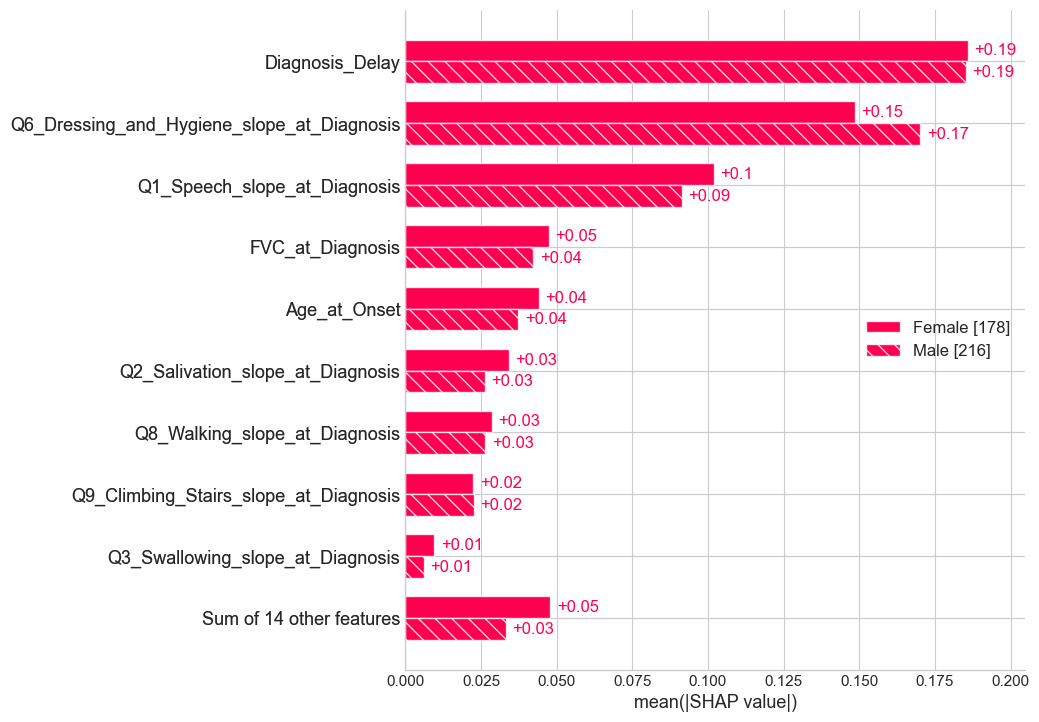

1 Site_Onset Site_Onset


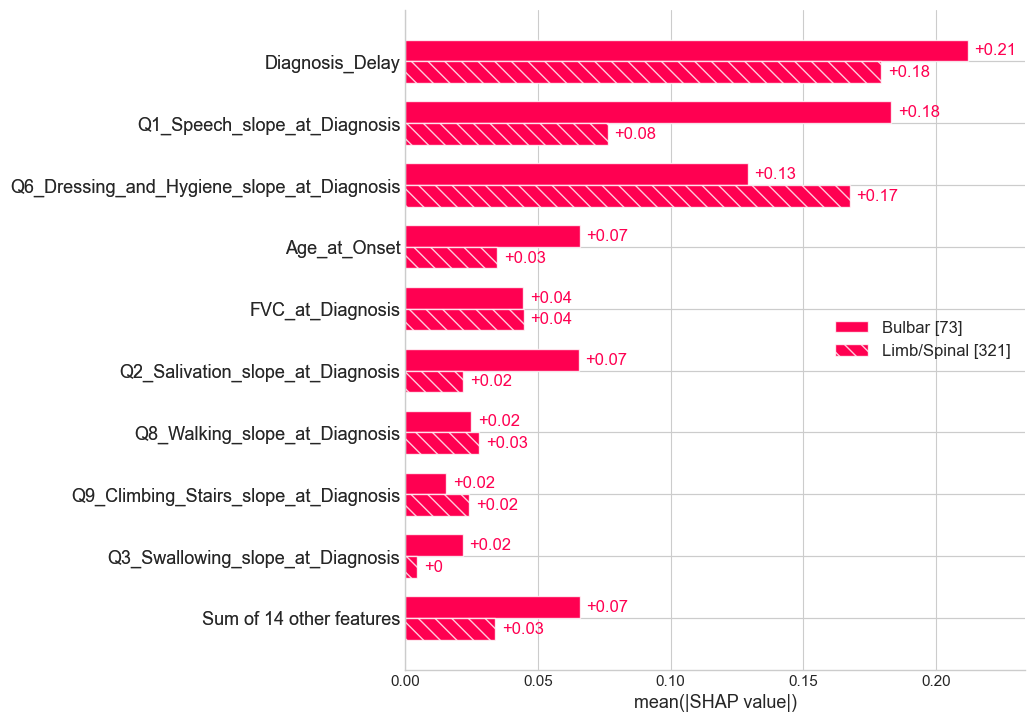

2 Diagnosis_Delay Diagnosis_Delay


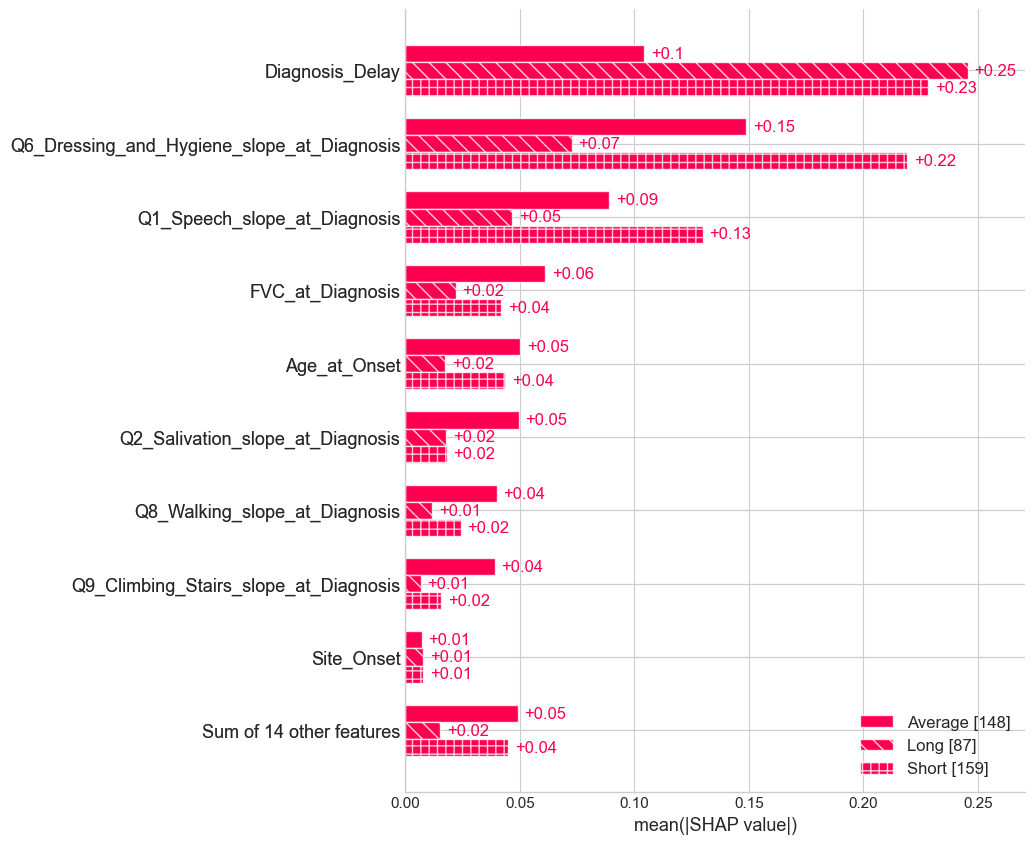

3 Age_at_Onset Age_at_Onset


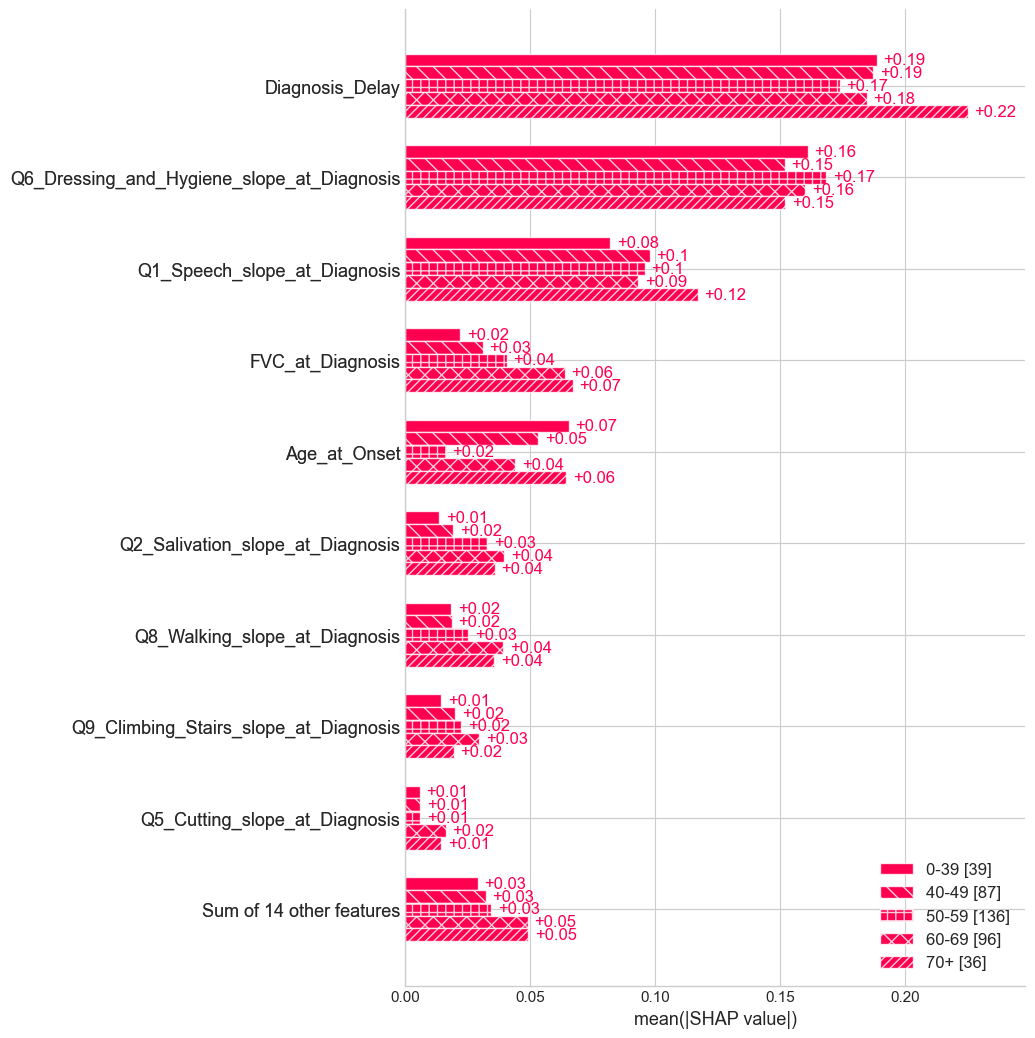

4 Riluzole Riluzole


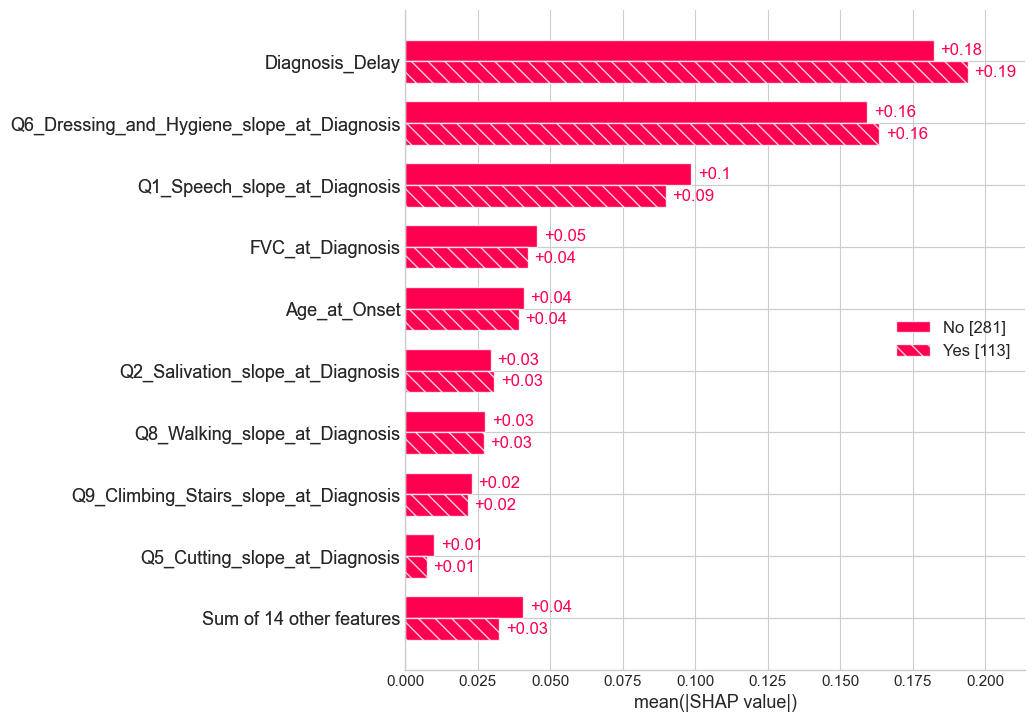

5 FVC_at_Diagnosis FVC_at_Diagnosis


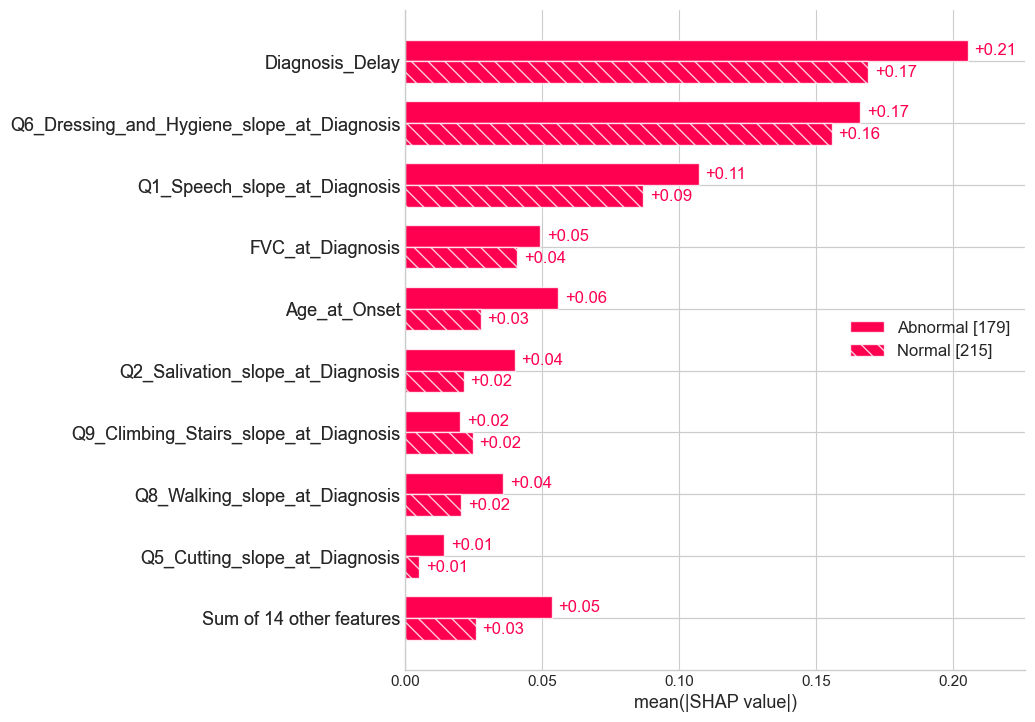

6 BMI_at_Diagnosis BMI_at_Diagnosis


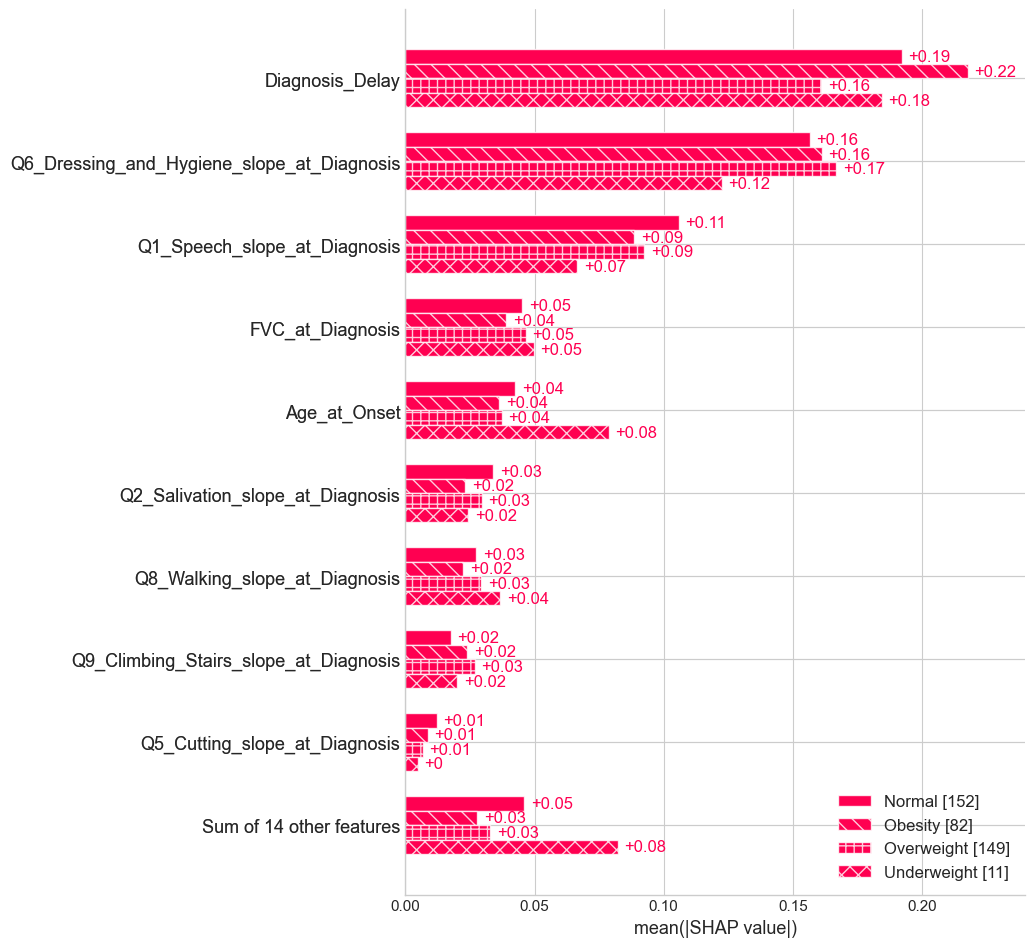

7 Q1_Speech_slope_at_Diagnosis Q1_Speech_slope_at_Diagnosis


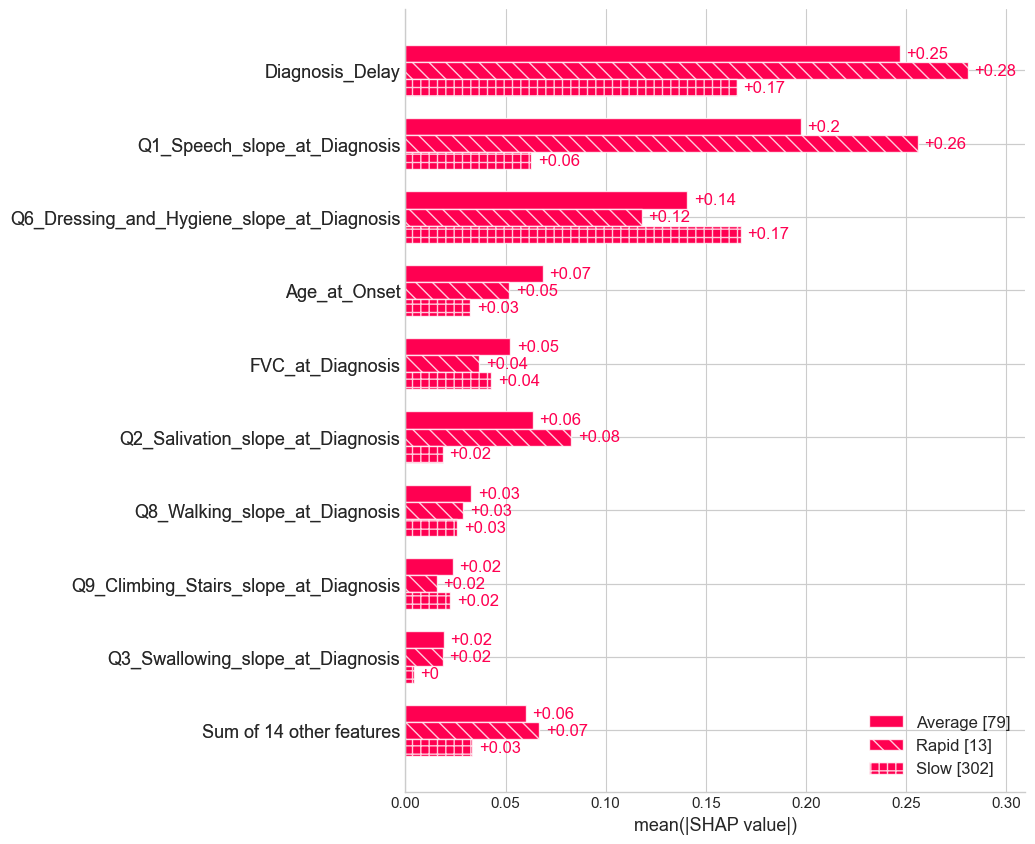

8 Q2_Salivation_slope_at_Diagnosis Q2_Salivation_slope_at_Diagnosis


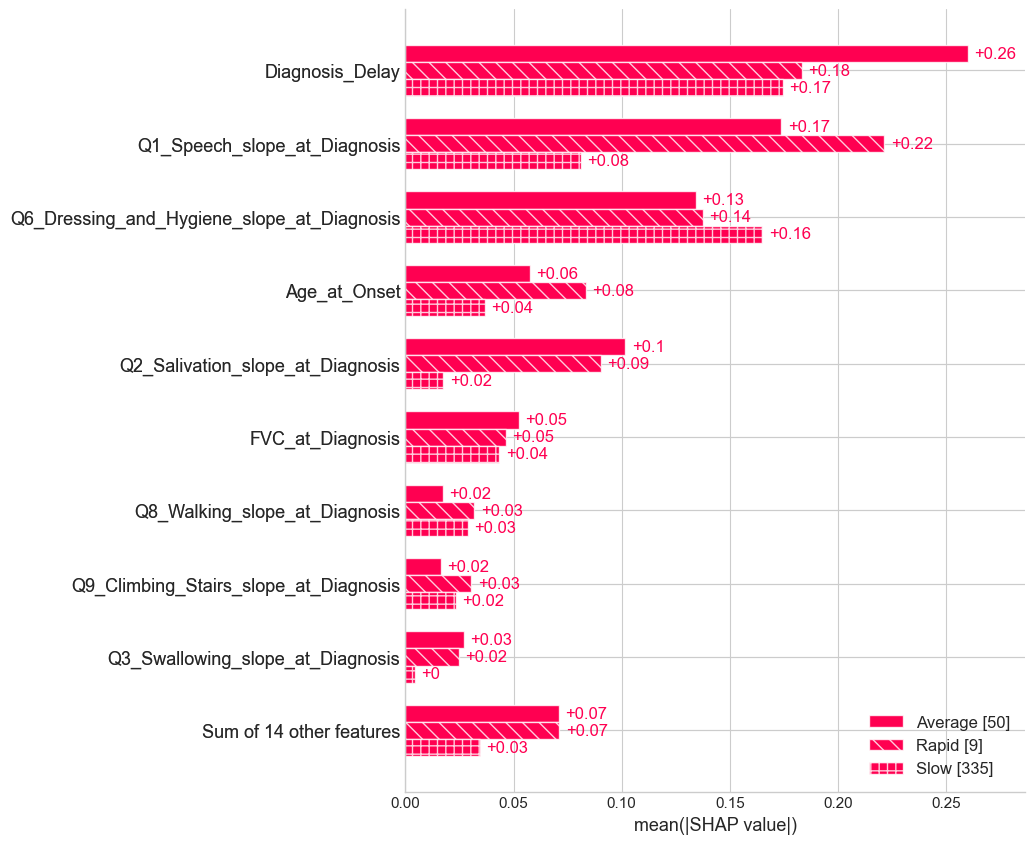

9 Q3_Swallowing_slope_at_Diagnosis Q3_Swallowing_slope_at_Diagnosis


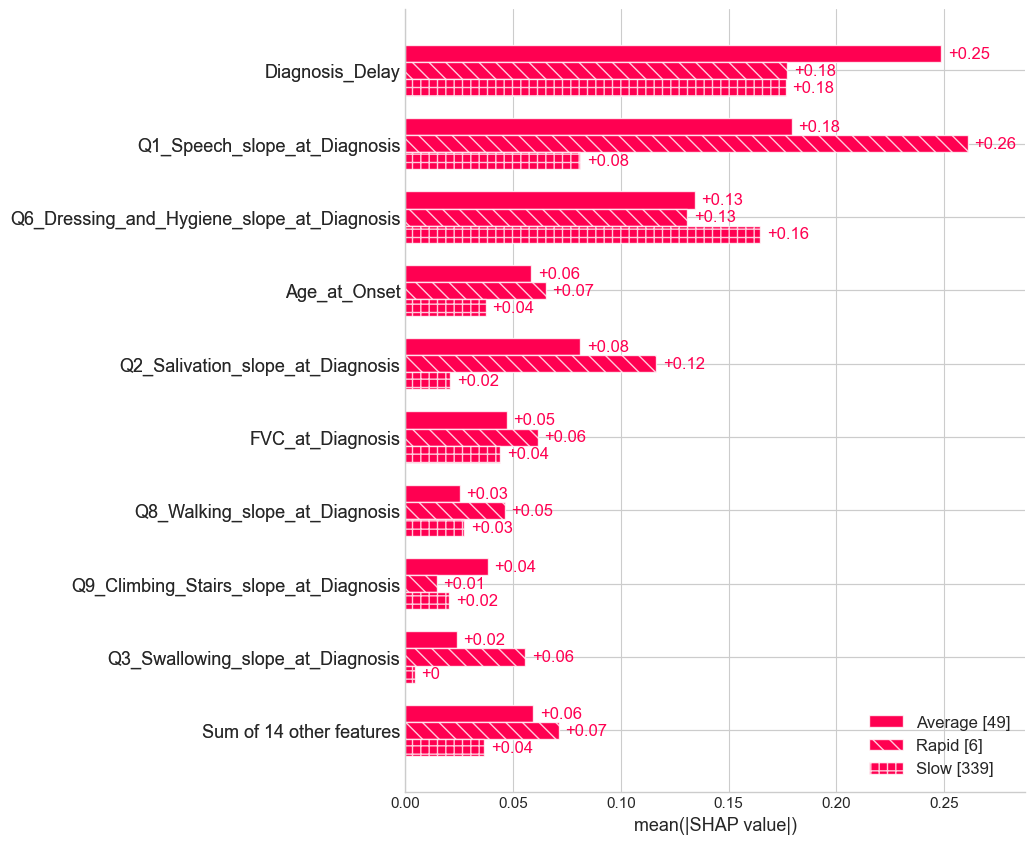

10 Q4_Handwriting_slope_at_Diagnosis Q4_Handwriting_slope_at_Diagnosis


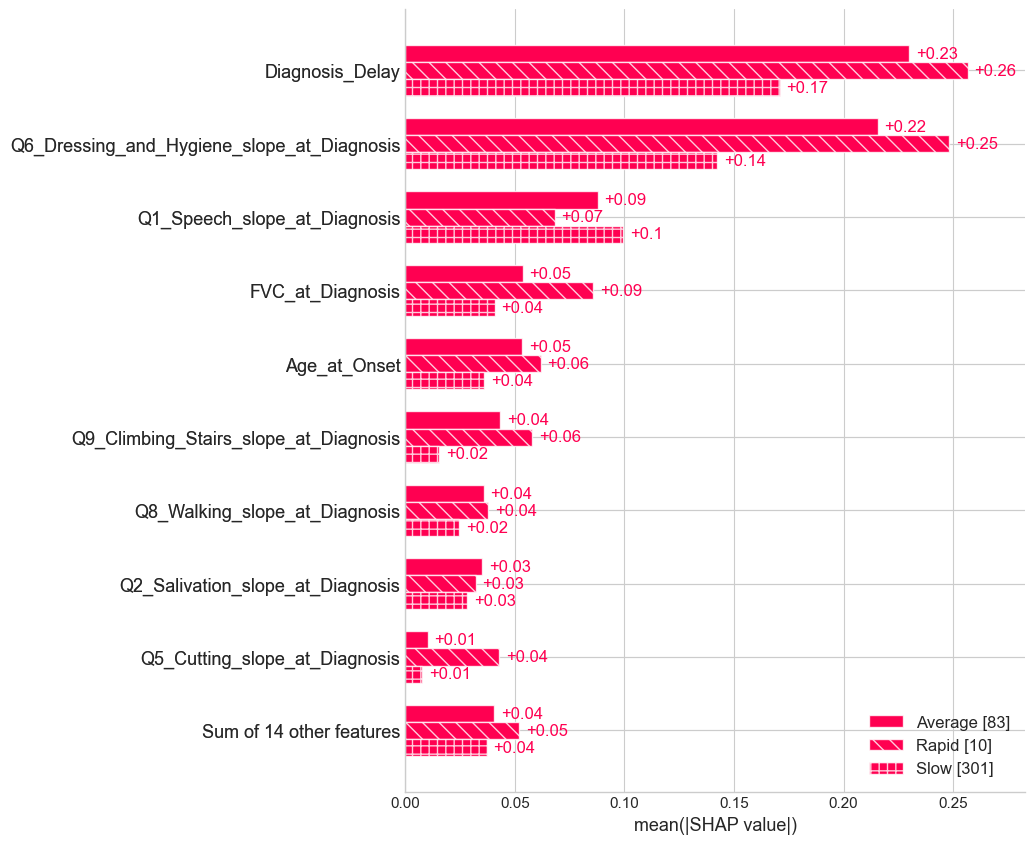

11 Q5_Cutting_slope_at_Diagnosis Q5_Cutting_slope_at_Diagnosis


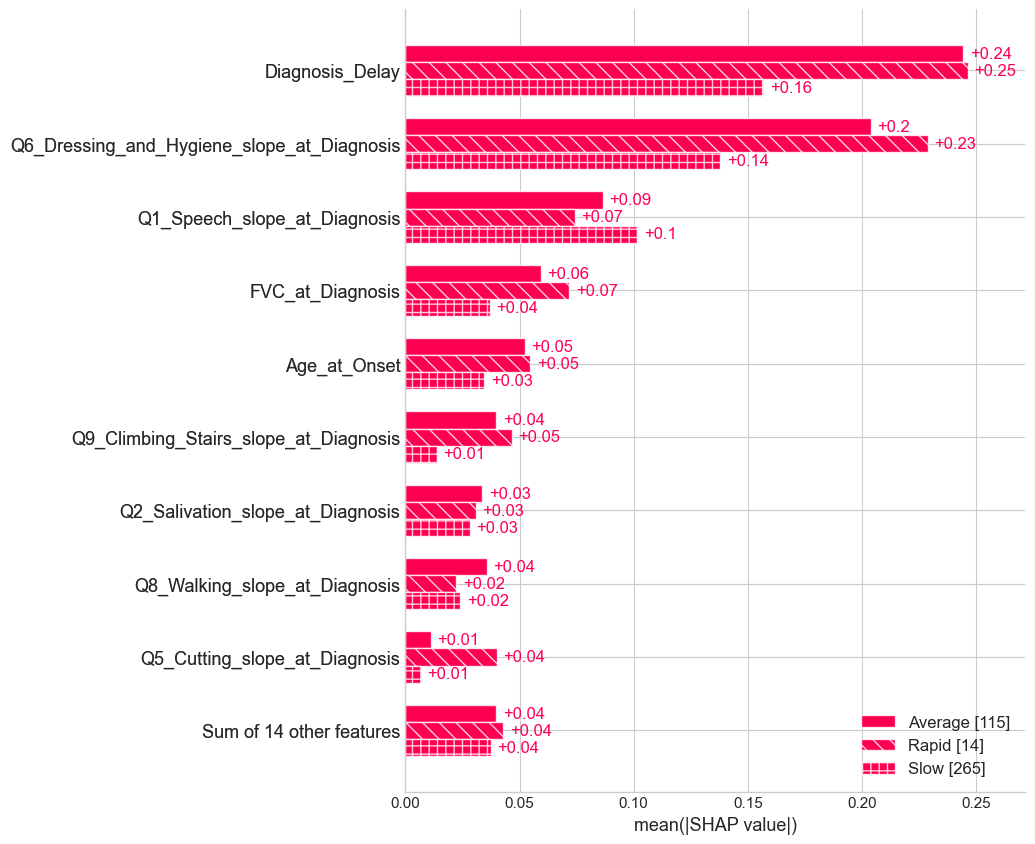

12 Q6_Dressing_and_Hygiene_slope_at_Diagnosis Q6_Dressing_and_Hygiene_slope_at_Diagnosis


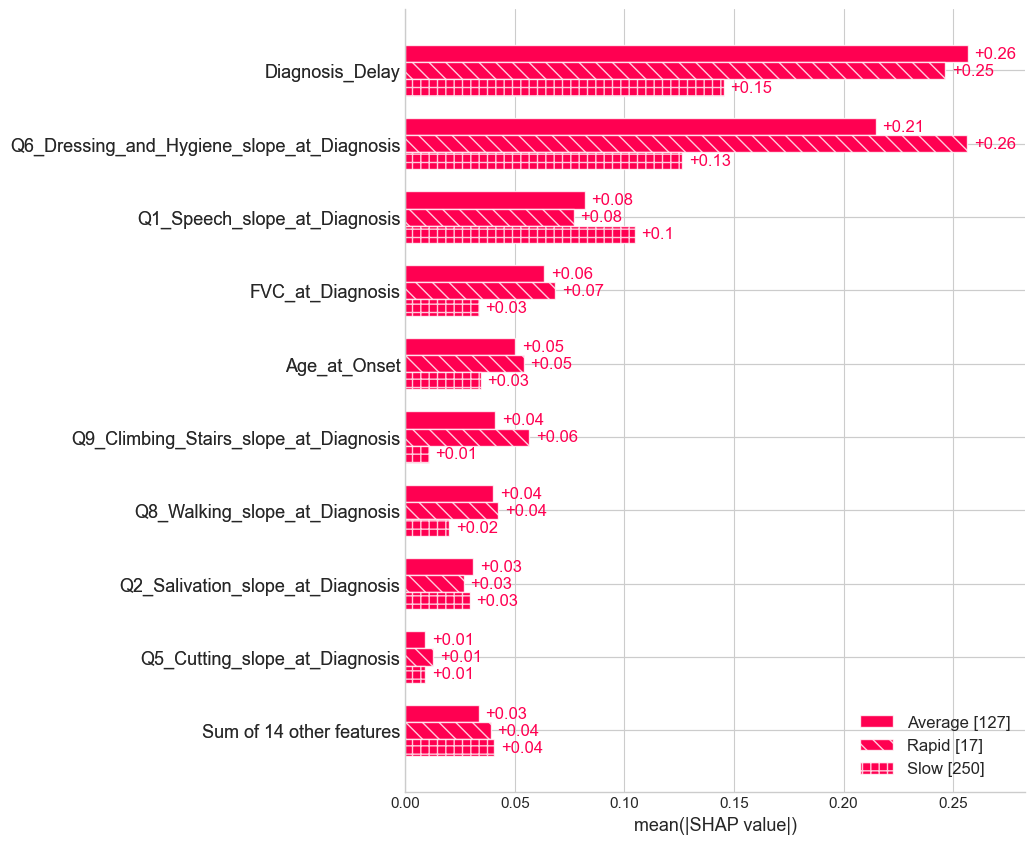

13 Q7_Turning_in_Bed_slope_at_Diagnosis Q7_Turning_in_Bed_slope_at_Diagnosis


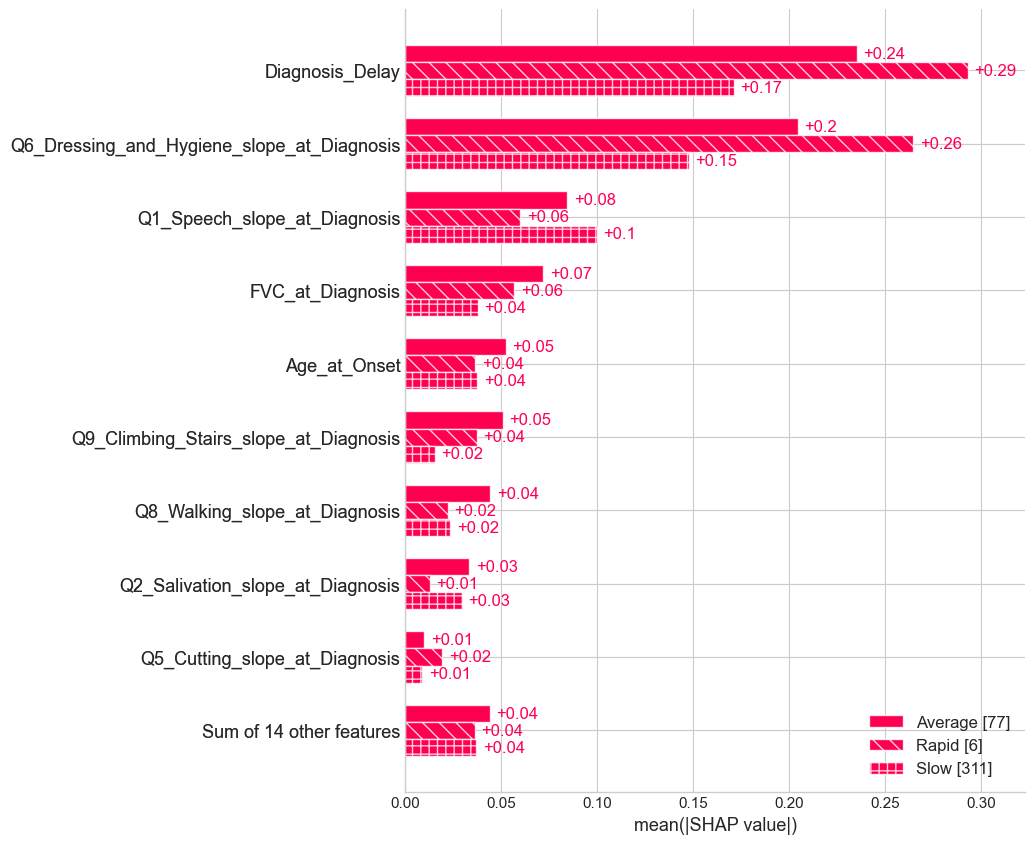

14 Q8_Walking_slope_at_Diagnosis Q8_Walking_slope_at_Diagnosis


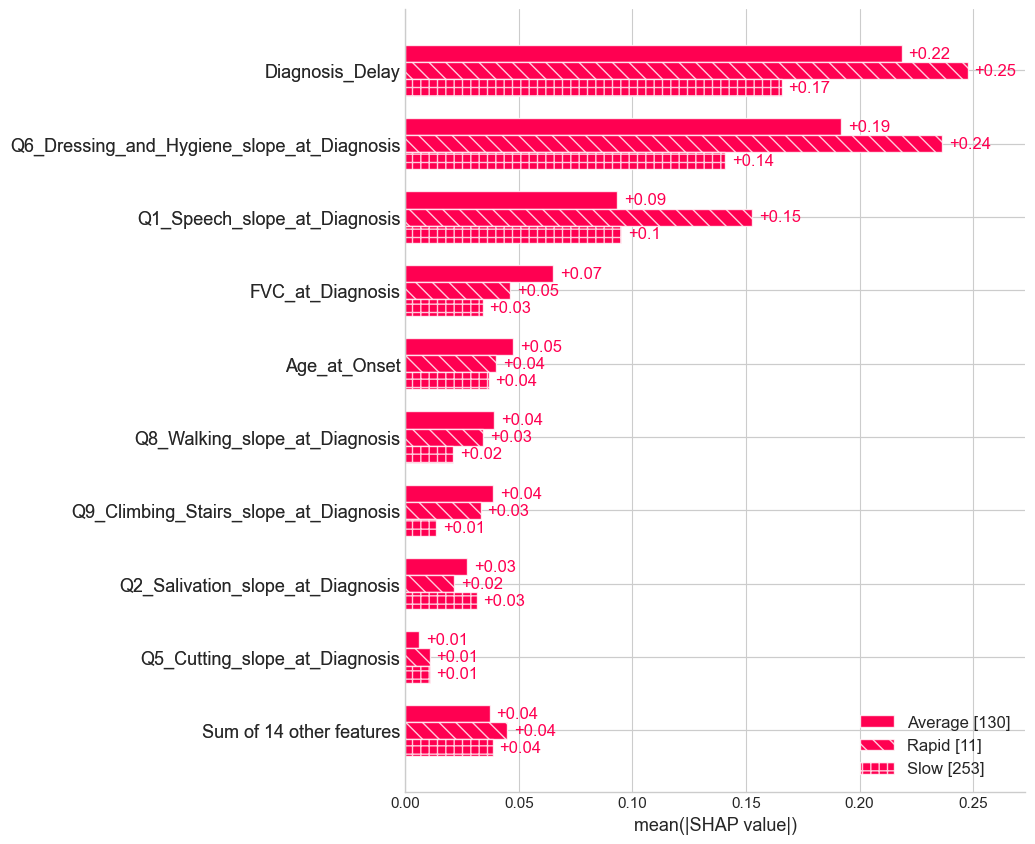

15 Q9_Climbing_Stairs_slope_at_Diagnosis Q9_Climbing_Stairs_slope_at_Diagnosis


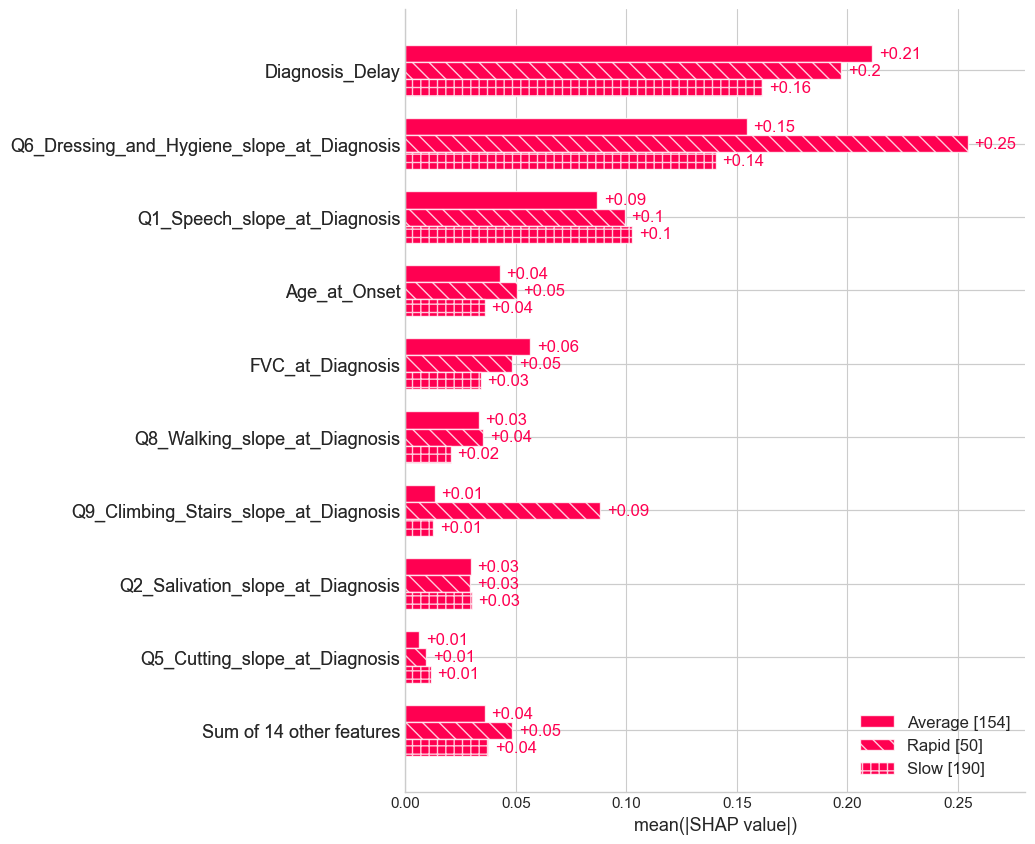

16 Q10_Respiratory_slope_at_Diagnosis Q10_Respiratory_slope_at_Diagnosis


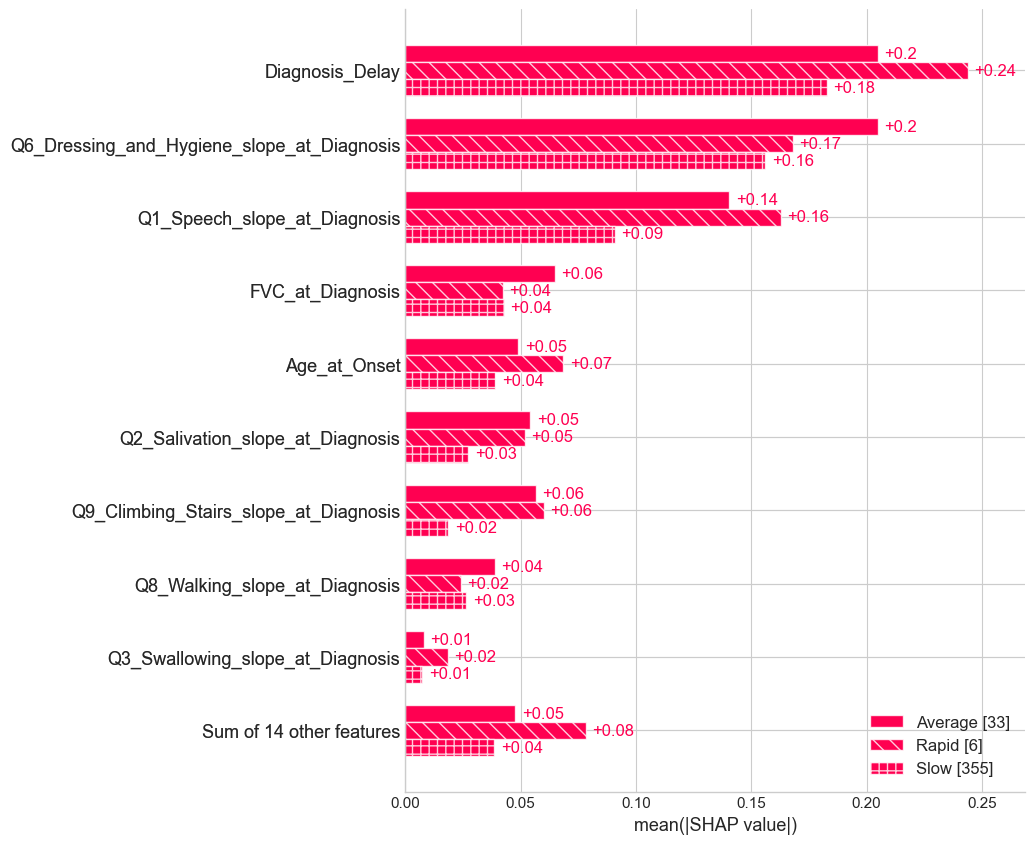

17 Qty_Regions_Involved_at_Diagnosis Qty_Regions_Involved_at_Diagnosis


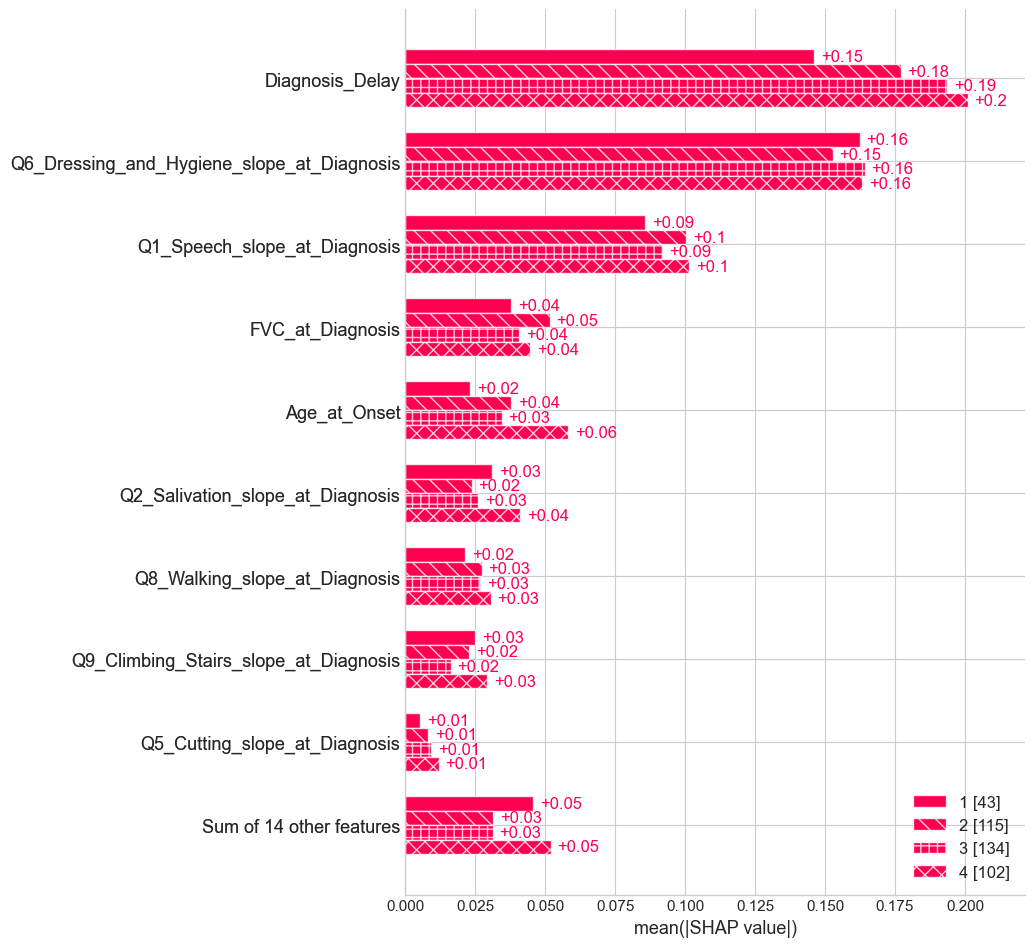

18 Region_Involved_Bulbar_at_Diagnosis Region_Involved_Bulbar_at_Diagnosis


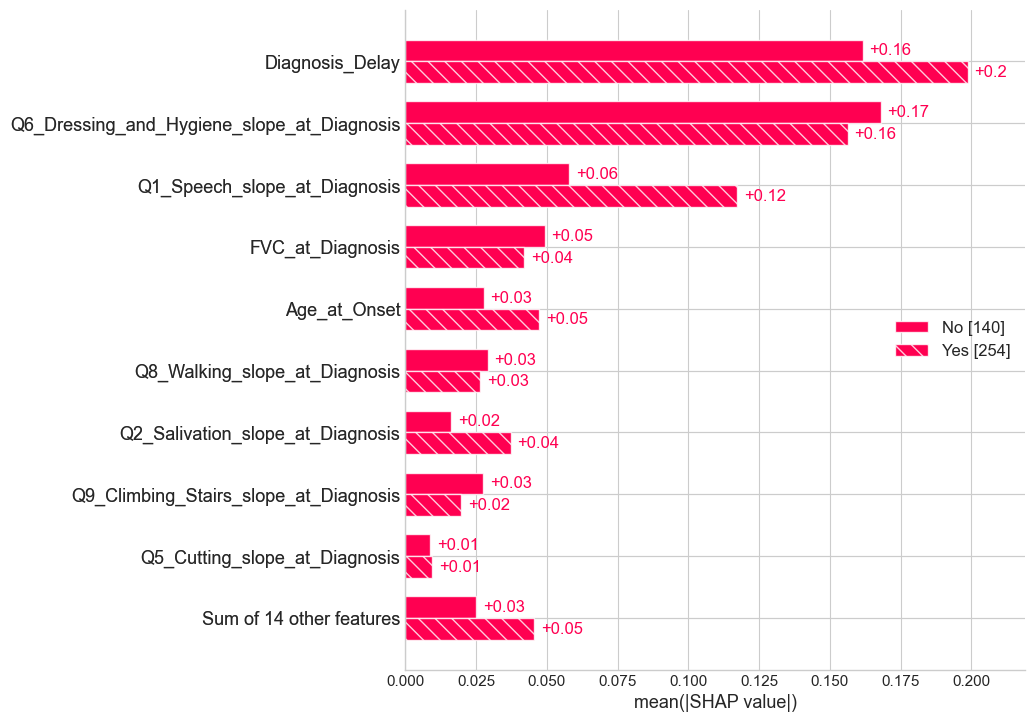

19 Region_Involved_Upper_Limb_at_Diagnosis Region_Involved_Upper_Limb_at_Diagnosis


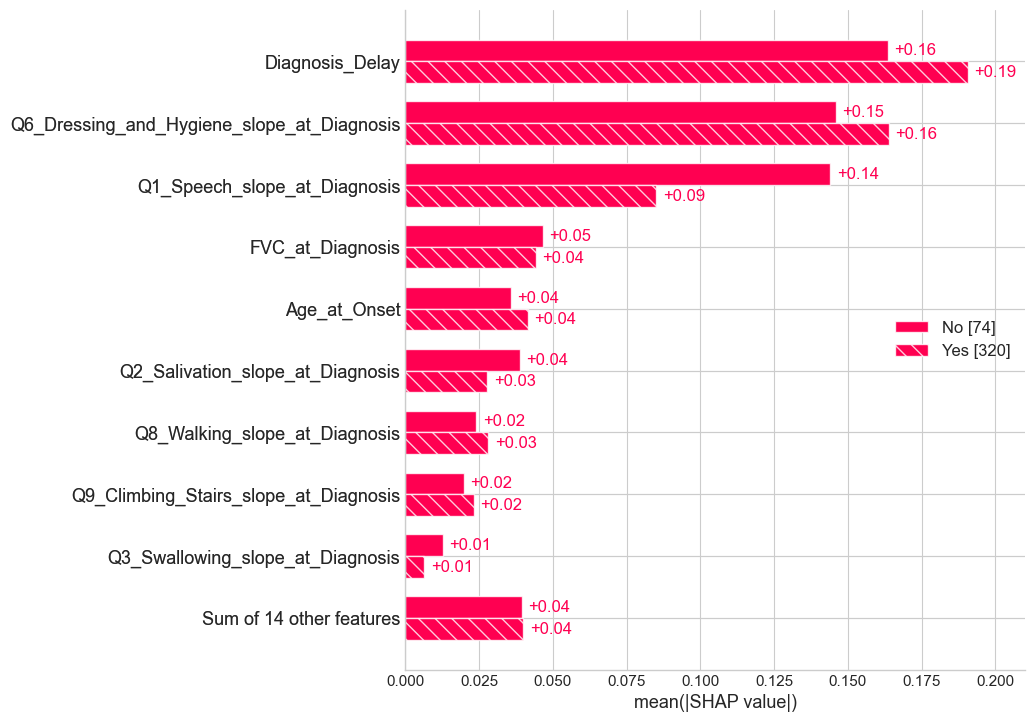

20 Region_Involved_Lower_Limb_at_Diagnosis Region_Involved_Lower_Limb_at_Diagnosis


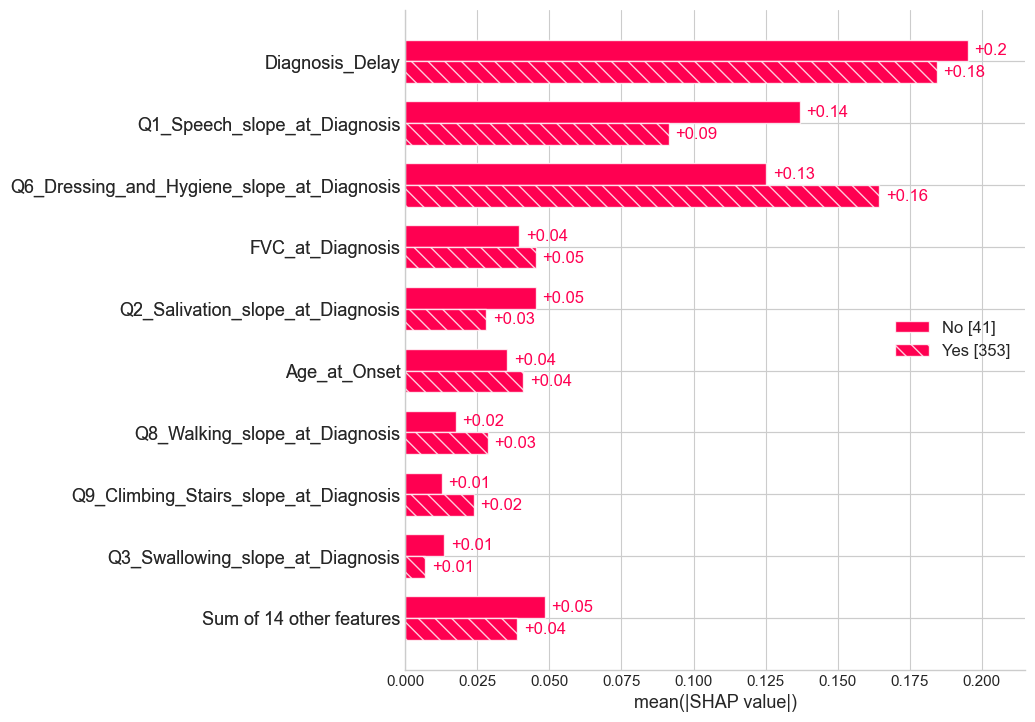

21 Region_Involved_Respiratory_at_Diagnosis Region_Involved_Respiratory_at_Diagnosis


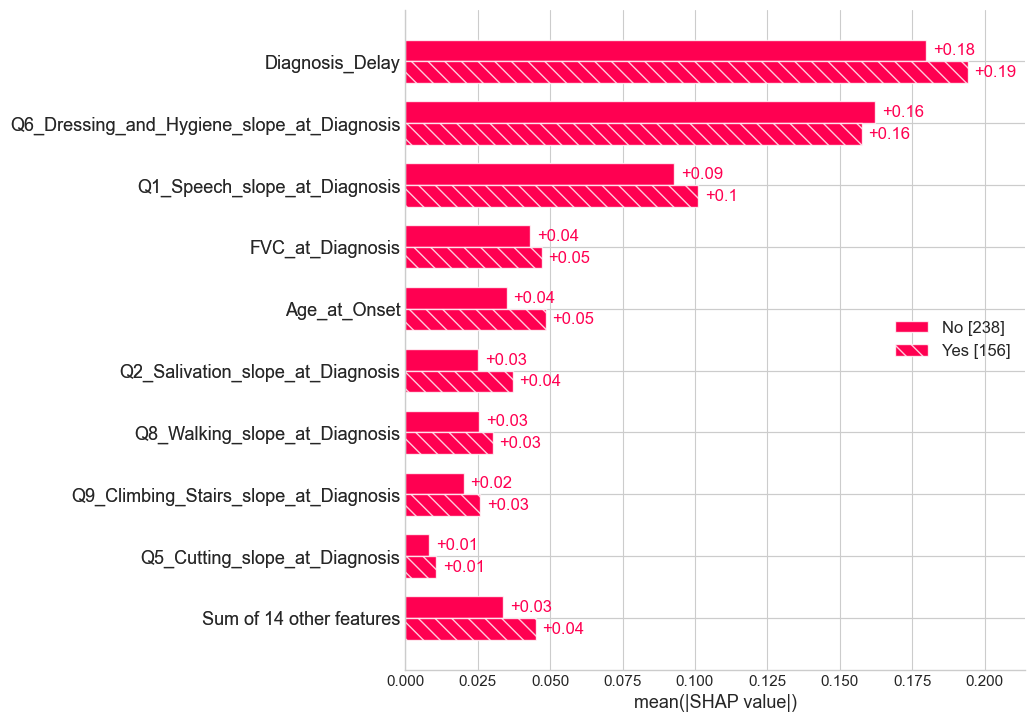

22 Patient_with_Gastrostomy_at_Diagnosis Patient_with_Gastrostomy_at_Diagnosis


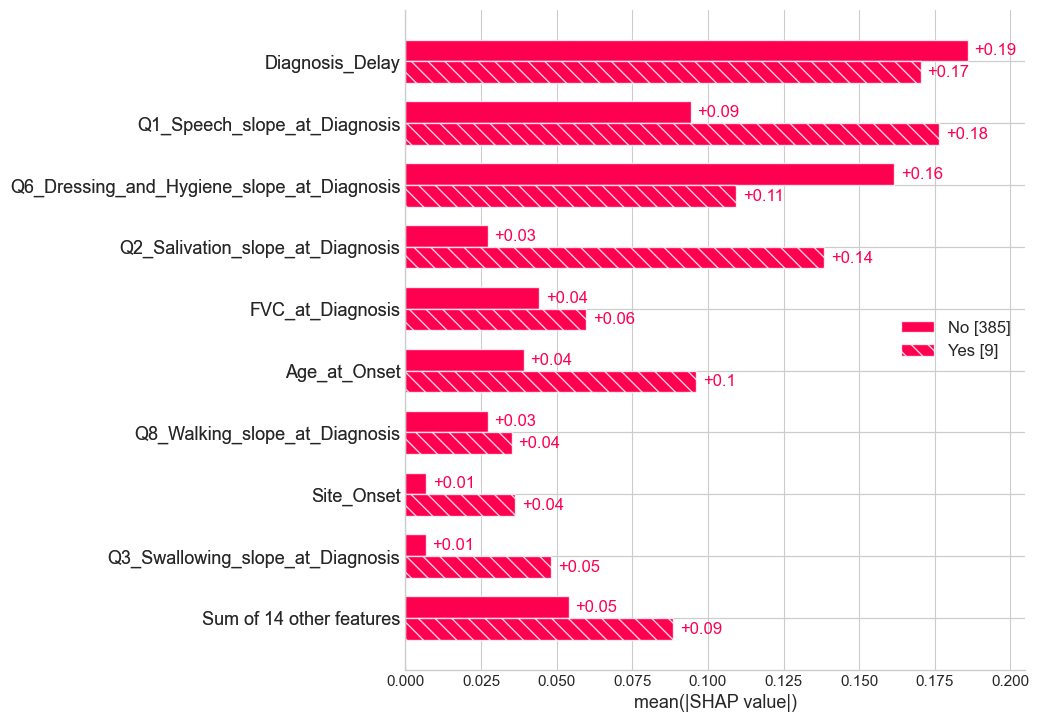

In [131]:

X_decoded = utils.get_decoded_data(df=X_valid)

display(X_decoded)


for i, f in enumerate(X_decoded.columns):
    print(i, f, shap_values.feature_names[i])
    cohort = X_decoded[f].values
    shap.plots.bar(shap_values.cohorts(cohort).abs.mean(0))



-------------
Beeswarm plot
-------------


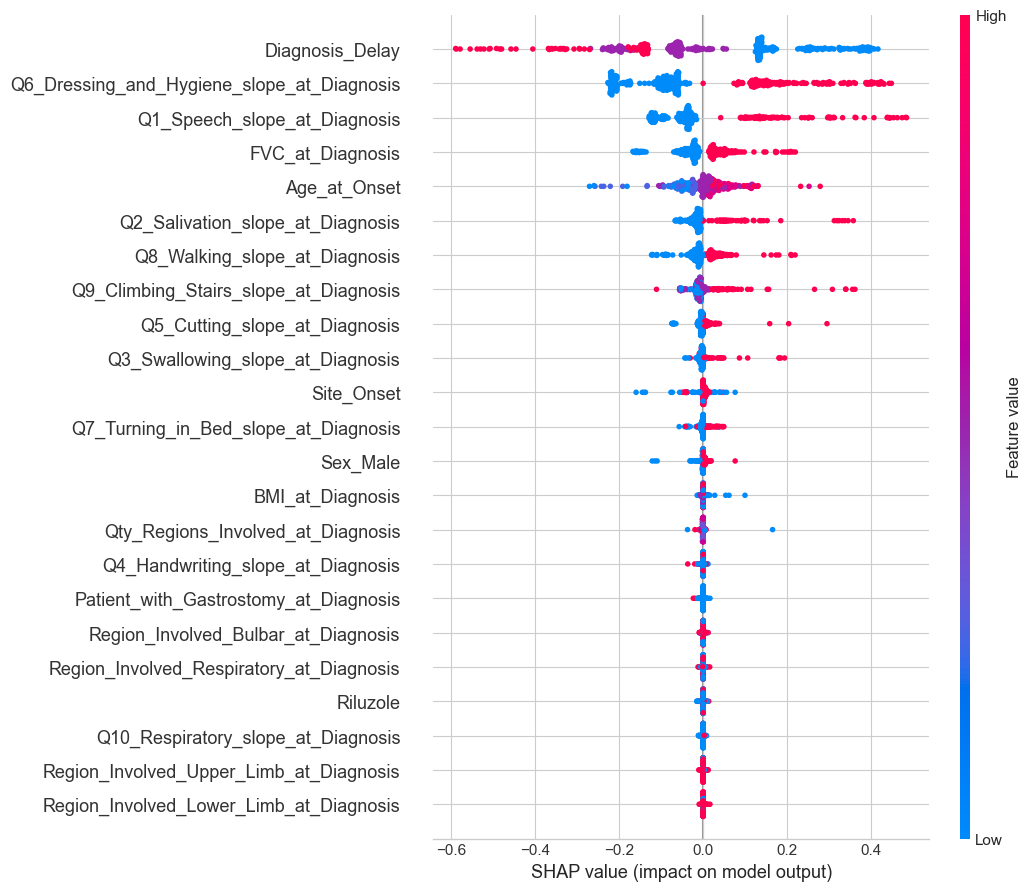

---------
Mean SHAP
---------


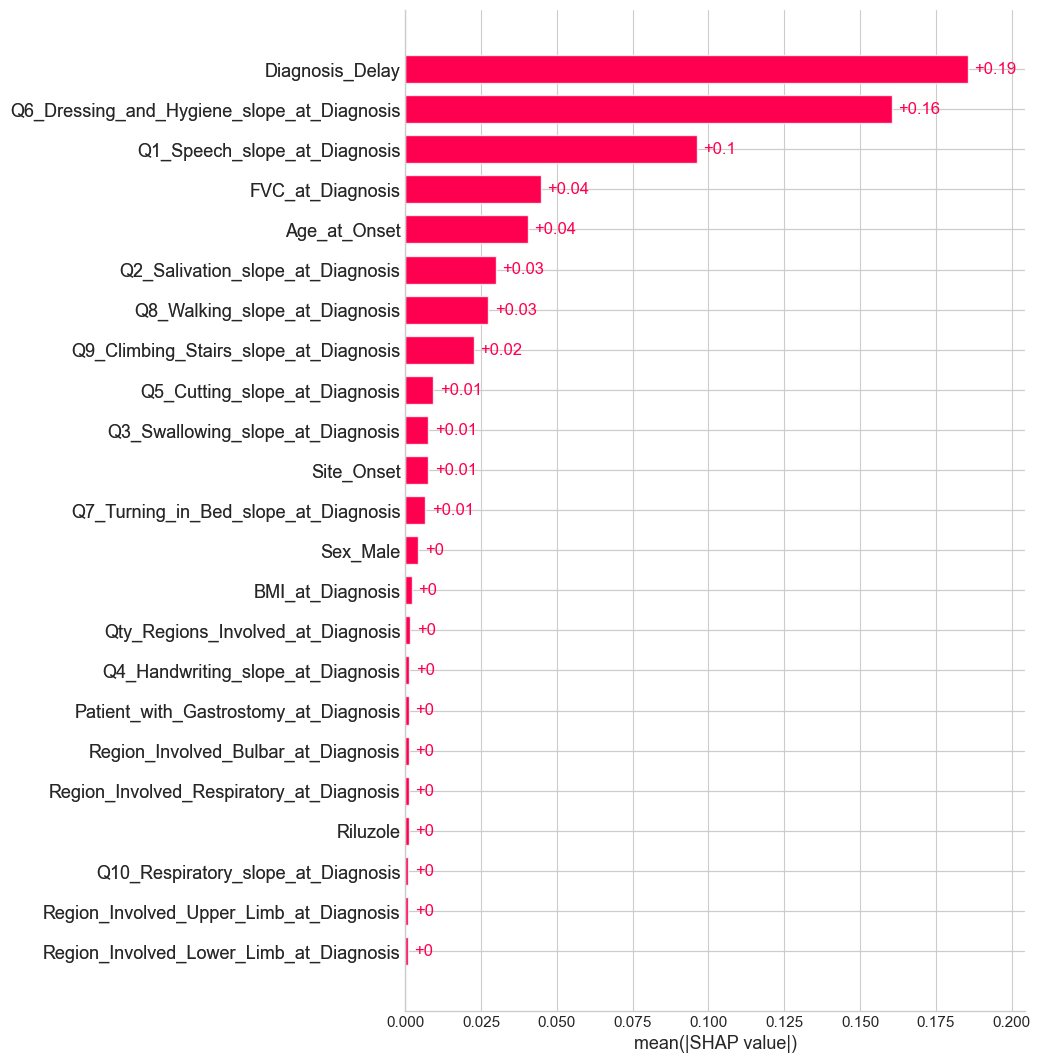

---------
Waterfall
---------


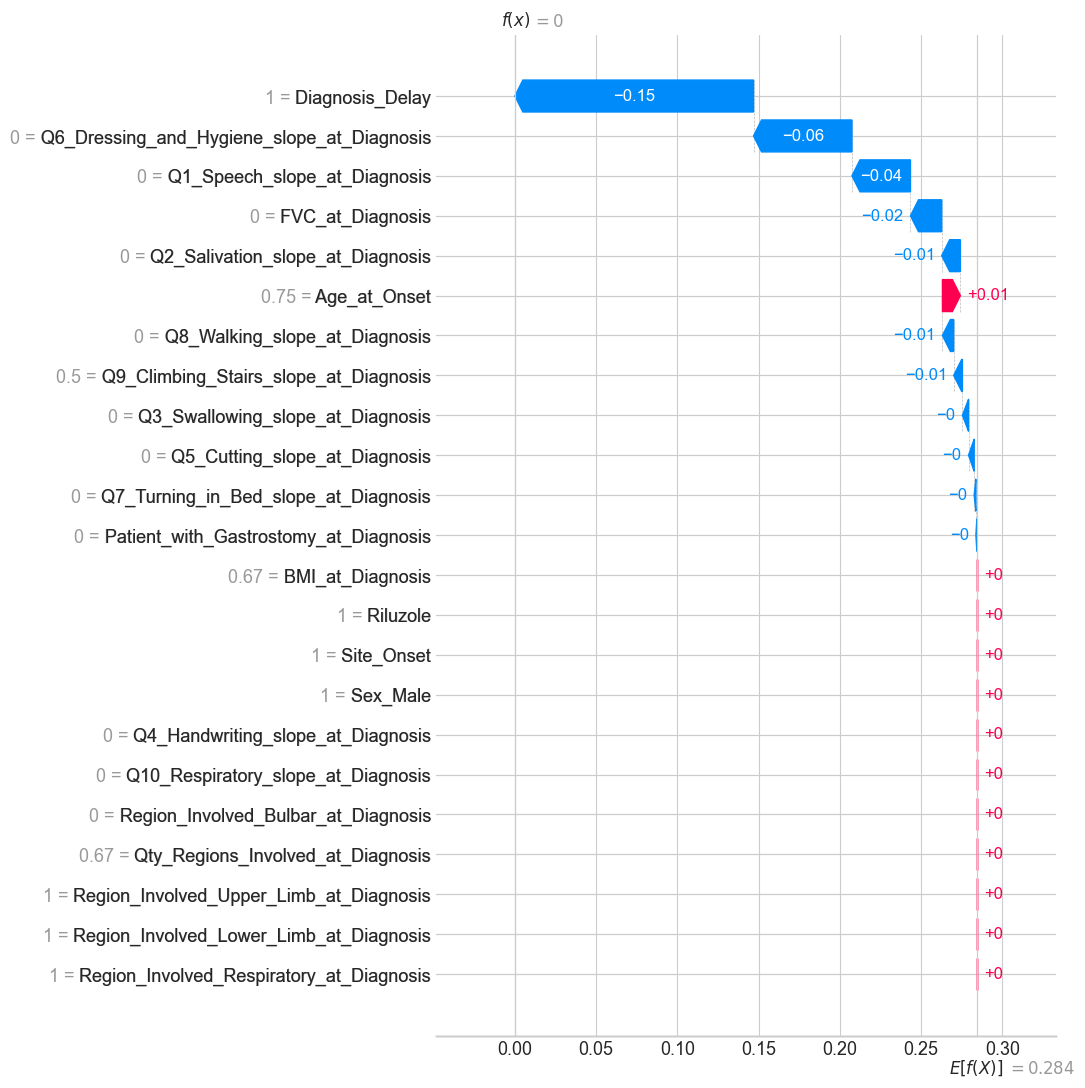

---------
Forceplot
---------
------------------
Stacked force plot
------------------


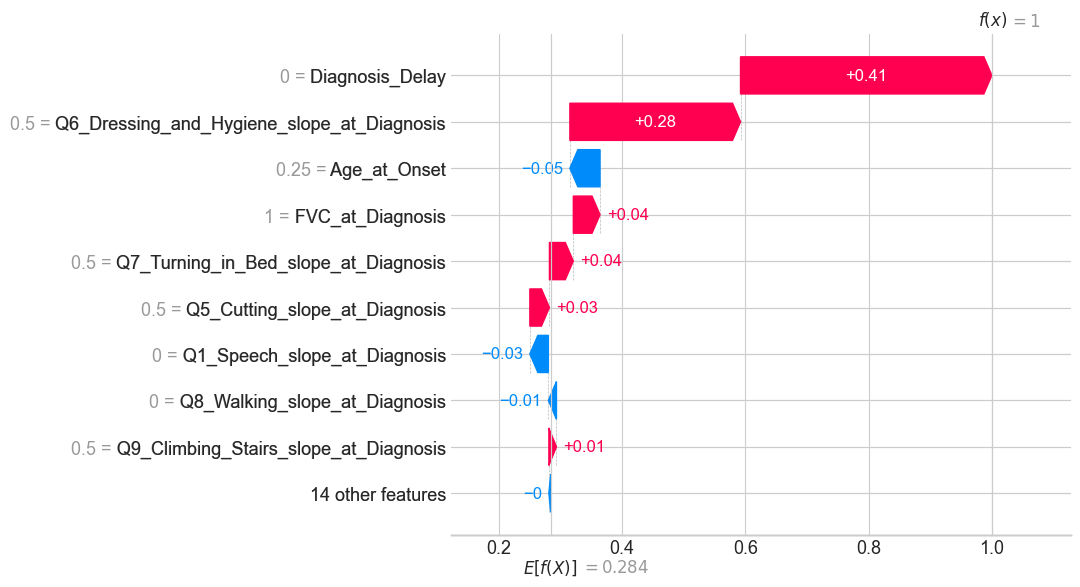

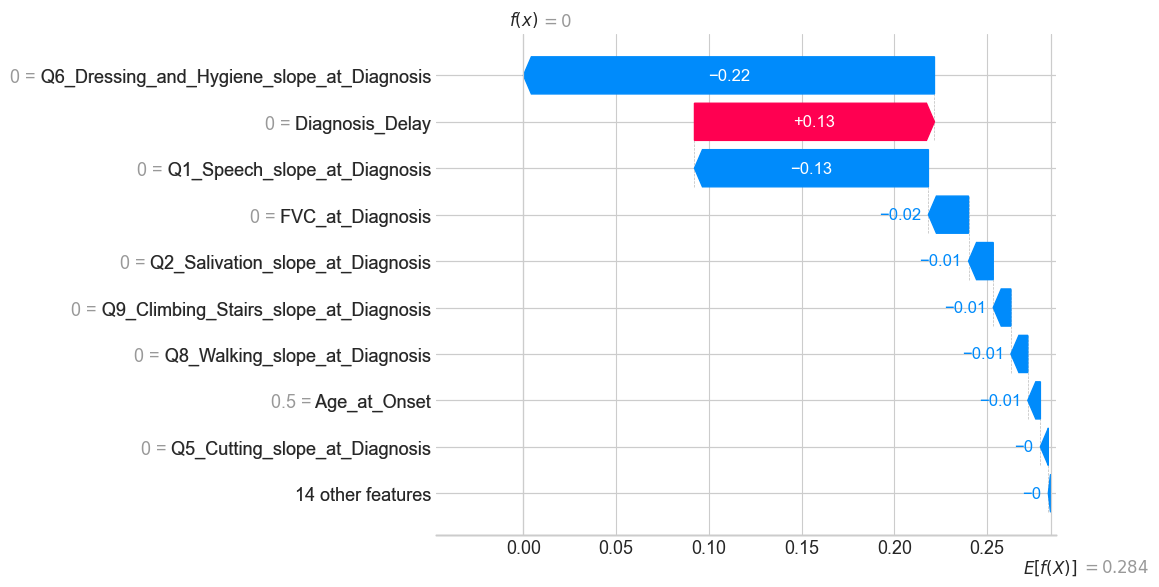

[]

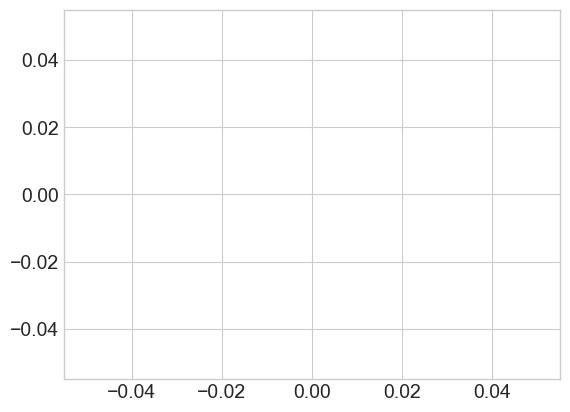

In [142]:
utils.print_string_with_separators('Beeswarm plot')
shap.plots.beeswarm(shap_values, max_display=25)
plt.plot()

utils.print_string_with_separators('Mean SHAP')
shap.plots.bar(shap_values, max_display=25)
plt.plot()

utils.print_string_with_separators('Waterfall')
shap.plots.waterfall(shap_values[0], max_display=25)
plt.plot()

utils.print_string_with_separators('Forceplot')
shap.plots.force(shap_values[0])
plt.plot()

utils.print_string_with_separators('Stacked force plot')
shap.plots.force(shap_values[0:500])
plt.plot()

shap.plots.waterfall(shap_values[200])
shap.plots.waterfall(shap_values[231])
plt.plot()


ValueError: setting an array element with a sequence.

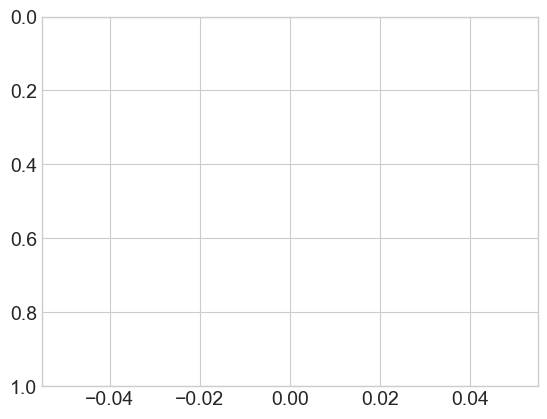

In [147]:
for feat1 in shap_values.feature_names[0:3]:
    for feat2 in shap_values.feature_names[0:3]:
        
        # fig, ax = plt.subplots()
        
        shap.plots.scatter(
            shap_values[:,feat1],
            color=shap_values[:,feat2],
            # ax=ax,
        )

        # utils.save_plot(
        #     plt=plt, 
        #     folder=f'temp_shap_plots/features_interaction', 
        #     file_name=f'{feat1}_vs_{feat2}', 
        #     save_in_pdf_format=False,
        # )
    
        # plt.close()



In [56]:
display(shap_values.feature_names)

['Sex_Male',
 'Site_Onset',
 'Diagnosis_Delay',
 'Age_at_Onset',
 'Riluzole',
 'FVC_at_Diagnosis',
 'BMI_at_Diagnosis',
 'Q1_Speech_slope_at_Diagnosis',
 'Q2_Salivation_slope_at_Diagnosis',
 'Q3_Swallowing_slope_at_Diagnosis',
 'Q4_Handwriting_slope_at_Diagnosis',
 'Q5_Cutting_slope_at_Diagnosis',
 'Q6_Dressing_and_Hygiene_slope_at_Diagnosis',
 'Q7_Turning_in_Bed_slope_at_Diagnosis',
 'Q8_Walking_slope_at_Diagnosis',
 'Q9_Climbing_Stairs_slope_at_Diagnosis',
 'Q10_Respiratory_slope_at_Diagnosis',
 'Qty_Regions_Involved_at_Diagnosis',
 'Region_Involved_Bulbar_at_Diagnosis',
 'Region_Involved_Upper_Limb_at_Diagnosis',
 'Region_Involved_Lower_Limb_at_Diagnosis',
 'Region_Involved_Respiratory_at_Diagnosis',
 'Patient_with_Gastrostomy_at_Diagnosis']

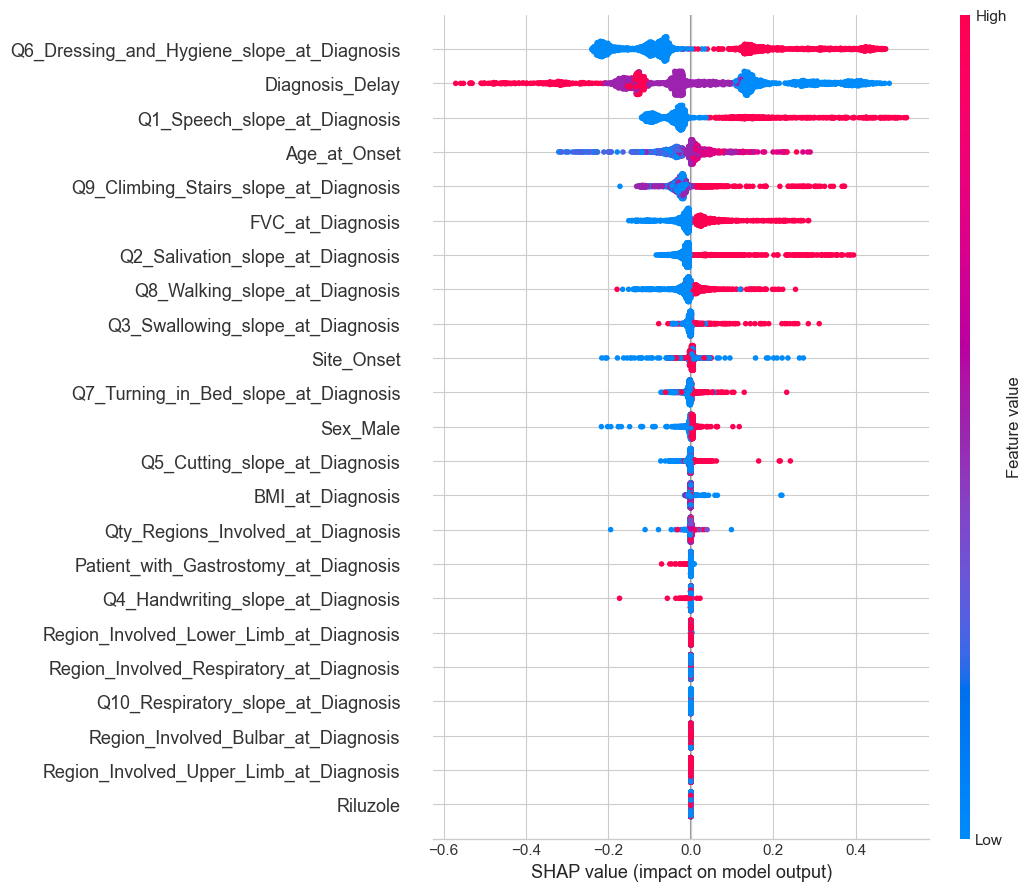

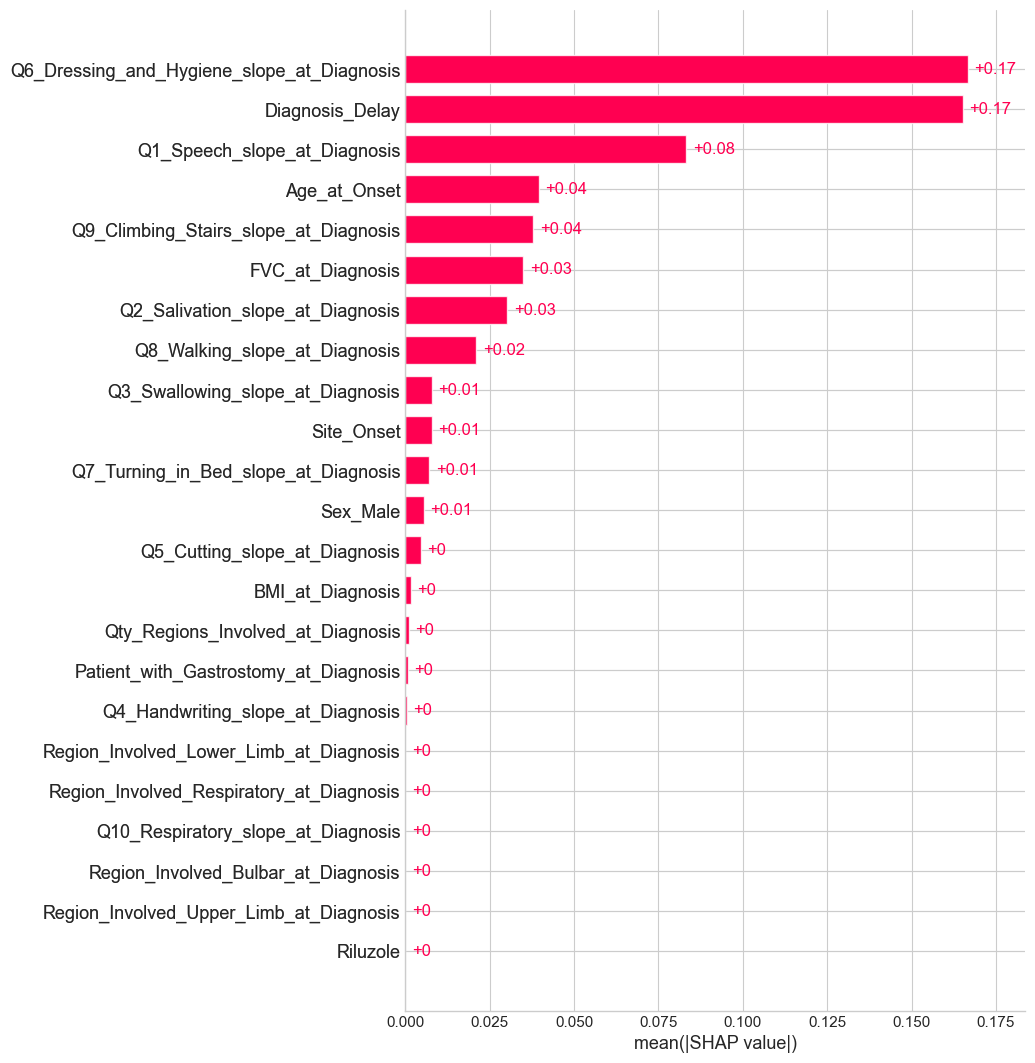

In [57]:

# Load all from disk to keep the example short.
with open(file_explainer_values, 'rb') as fl:
    shap_values_loaded = pickle.load(fl)

# display(shap_values_loaded)

# class_count = len(shap_values_loaded.base_values)
# display(class_count)


shap.plots.beeswarm(
    shap_values_loaded, 
    max_display=25
)

shap.plots.bar(
    shap_values_loaded, 
    max_display=25,
)


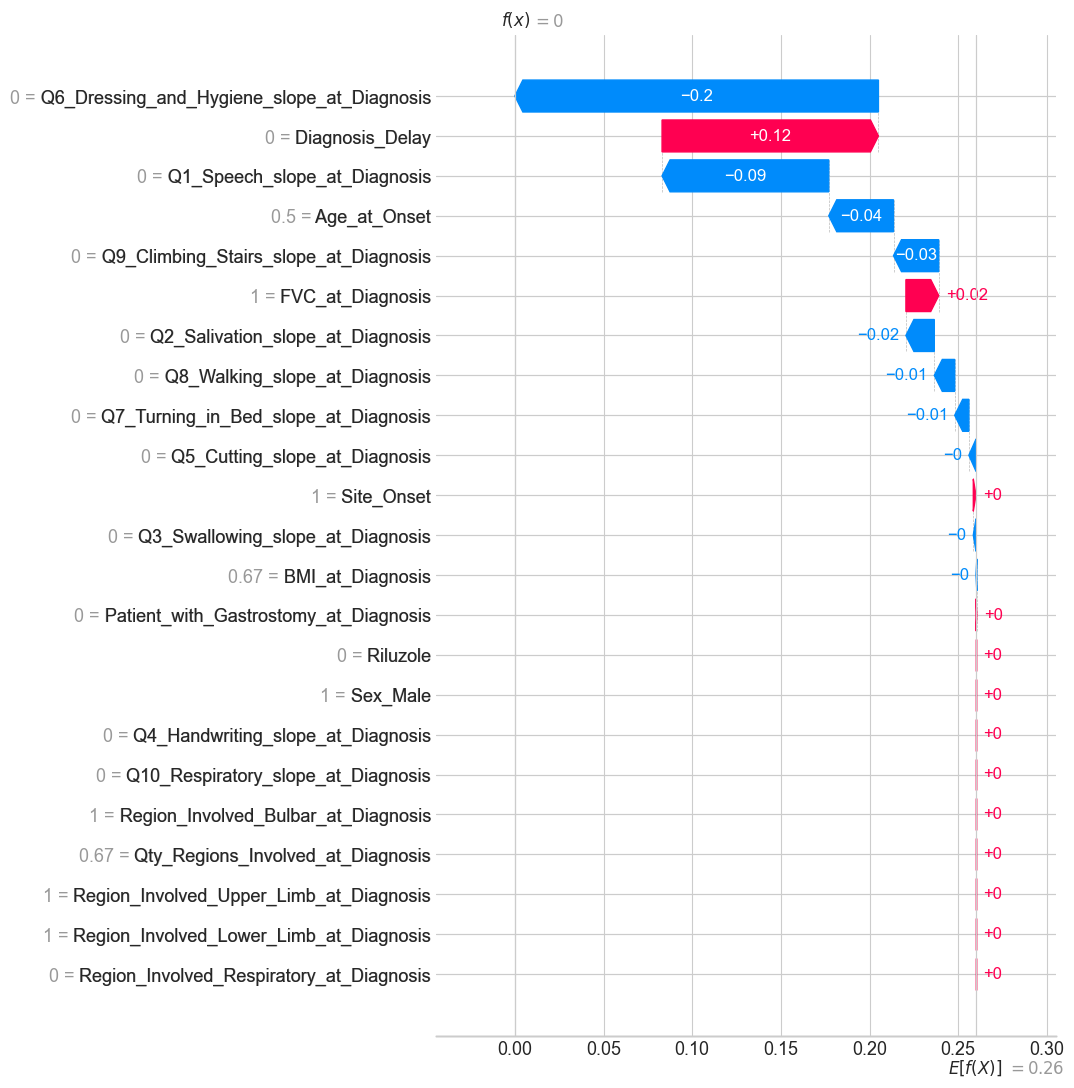

In [64]:
shap.plots.waterfall(shap_values[0], max_display=25)